In [1]:

%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
sys.path.append('C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict
from slab import Experiment, dsfit, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Warning serial library import failed.
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver


In [2]:
from slab.dsfit import *
import os
from scipy.interpolate import griddata
from numpy import mgrid, array, zeros,abs,pi,cos,transpose, linspace
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from tempfile import TemporaryFile
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
import json
from h5py import File
from datetime import datetime
import time
from slab.datamanagement import SlabFile
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from slab.dsfit import *
from scipy.optimize import curve_fit
# import experiments.fitting as fitter
from matplotlib.colors import Normalize
import matplotlib

## Import modules from parent and multimode expts

In [3]:
import json
import os

# Get the current working directory
path = os.getcwd()
print("Current Path:", path)

# Isolate the parent directory
parent_path = os.path.dirname(path)
print("Parent Path:", parent_path)

# Add the parent path to the sys.path
sys.path.append(parent_path)

Current Path: c:\_Lib\python\multimode_expts\analysis_notebooks\temperature
Parent Path: c:\_Lib\python\multimode_expts\analysis_notebooks


In [4]:
import sys

# Path to add
expts_path = 'C:\\_Lib\\python\\multimode_expts'

# Add the path to the system path at the highest priority
if expts_path not in sys.path:
    sys.path.insert(0, expts_path)
    print('Path added at highest priority')

# Verify the path is added
print(sys.path)


Path added at highest priority
['C:\\_Lib\\python\\multimode_expts', 'c:\\_Lib\\python\\multimode_expts\\analysis_notebooks\\temperature', 'C:\\_Lib\\python', 'C:\\_Lib\\python\\slab', 'C:\\_Lib\\python\\qick\\qick_lib', 'C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts', 'c:\\_Lib\\python\\multimode_expts\\analysis_notebooks\\temperature', 'c:\\Users\\26049\\.conda\\envs\\slab\\python38.zip', 'c:\\Users\\26049\\.conda\\envs\\slab\\DLLs', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib', 'c:\\Users\\26049\\.conda\\envs\\slab', '', 'C:\\Users\\26049\\AppData\\Roaming\\Python\\Python38\\site-packages', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\easy_lmfit-1.0-py3.8.egg', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\attrdict-2.0.1-py3.8.egg', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32\\lib', 'c:\\Users\\26049\\

In [17]:
from multimode_expts.fit_display import *

importing from path  C:\_Lib\python\multimode_expts\experiments\clifford_averager_program.py
imported experiments.clifford_averager_program
importing from path  C:\_Lib\python\multimode_expts\experiments\fitting.py
imported experiments.fitting
importing from path  C:\_Lib\python\multimode_expts\experiments\qram_protocol_timestepped.py
imported experiments.qram_protocol_timestepped
importing from path  C:\_Lib\python\multimode_expts\experiments\qubit_cavity
imported experiments.qubit_cavity.amplitude_rabi_f0g1
imported experiments.qubit_cavity.displacement_enhanced_sideband
imported experiments.qubit_cavity.displace_amplitude_calibration
imported experiments.qubit_cavity.displace_pulse_probe
imported experiments.qubit_cavity.ecd
imported experiments.qubit_cavity.ecd_backup
imported experiments.qubit_cavity.ecd_read_spec
imported experiments.qubit_cavity.non_demolution_readout
imported experiments.qubit_cavity.out_and_back
imported experiments.qubit_cavity.photo_resolved_pulse_probe
impo

In [18]:
import experiments.fitting as fitter
from numpy.linalg import inv

# Exp path

In [19]:

# print("path: ", path)

"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'\\'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        # print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

data_parent =  r'H:\Shared drives\SLab\Multimode\experiment\240911'
expt_path=data_parent+'\\data1'
print('Data are extracted from', expt_path)

Data are extracted from H:\Shared drives\SLab\Multimode\experiment\240911\data1


# parity detection temperature

## Markovian model

In [20]:
from pylab import*

In [84]:
def get_evolution_matrices(attrs):
    '''Return Trnasmisson and Reflection matrices'''
    # device parameters
    trigger_period = 2.5+1 # all times in micro seconds (1us readout, 2.5 relaxation delay, )
    man_no = attrs['config']['expt']['man_no']
    parity_time = attrs['config']['device']['manipulate']['revival_time'][man_no - 1]
    print('parity_time', parity_time)
    # parity_time = 1.7366205852286094
    cav_t1 = 209 # man 1 T1
    if man_no == 2: 
        print('using man 2 T1')
        cav_t1 = 120  # man 2 T1
    qubit_t1 = 368 #493 # qubit decay time
    qubit_t2 = 148 #259 # qubit dephasing time
    # cav_n = 7.3e-4
    cav_n= 0.0
    qubit_n = 1.59e-2 # residual qubit population

    confusion_matrix = attrs['config']['device']['readout']['confusion_matrix_without_reset']
    if attrs['config']['expt']['active_reset']:
        print('using active reset confusion matrix')
        confusion_matrix = attrs['config']['device']['readout']['confusion_matrix_with_reset']
    
    g_infidelity = 1-confusion_matrix[0]#, 0.0032428050263477726, 0.016634449079255258, 0.9833655509207447#0.9889999999999999#, 0.01100000000000012, 0.024800000000000003, 0.9752##0.9900000000000003 # infidelity of qubit g readout   no active reset
    e_infidelity = 1-confusion_matrix[-1]#0.9764 # infidelity of qubit e readout   no active reset
    print('g_infidelity', g_infidelity)
    print('e_infidelity', e_infidelity)
    parity_err = 0

    P01 = cav_n * (1-exp(-trigger_period/cav_t1))
    P10 = 1-exp(-trigger_period/cav_t1)
    Pge = qubit_n * (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2)) + parity_err
    Peg = (1-exp(-trigger_period/qubit_t1)) + (1-exp(-parity_time/qubit_t2)) + parity_err

    T = asarray([[(1-P01)*(1-Pge), (1-P01)*Pge, P01*Pge, P01*(1-Pge)],
        [(1-P01)*Peg, (1-P01)*(1-Peg), P01*(1-Peg), P01*Peg],
        [P10*(1-Pge), P10*Pge, (1-P10)*Pge, (1-P10)*(1-Pge)],
        [P10*Peg, P10*(1-Peg), (1-P10)*(1-Peg), (1-P10)*Peg]])

    E = 0.5*asarray([[1-g_infidelity, g_infidelity],
        [e_infidelity, 1- e_infidelity],
        [1-g_infidelity, g_infidelity],
        [e_infidelity, 1- e_infidelity]])
    
    return T, E



In [81]:
T, E = get_evolution_matrices(attrs)
print('T', T)
print('E', E)

parity_time 1.6833333333333333
g_infidelity 0.008900000000000019
e_infidelity 0.024800000000000044
T [[9.88540058e-01 1.14599419e-02 0.00000000e+00 0.00000000e+00]
 [2.07752202e-02 9.79224780e-01 0.00000000e+00 0.00000000e+00]
 [1.64166549e-02 1.90314909e-04 1.12696270e-02 9.72123403e-01]
 [3.45013454e-04 1.62619563e-02 9.62962823e-01 2.04302067e-02]]
E [[0.49555 0.00445]
 [0.0124  0.4876 ]
 [0.49555 0.00445]
 [0.0124  0.4876 ]]


In [82]:
# State reconstrution algorithms for the HMM

# 
def forward(meas_seq, T, E):
    '''
    probability of possible state at i-th time step given all previous measurements
    
    N = # of states in system
    alpha[i,j] = At i'th measurement, probability of being in state j (states are product states of cavity and qubit )

    meas_seq[i] = at i'th measurement, which state was observed (g or e )
    
    '''
    num_meas = len(meas_seq)
    N = T.shape[0]
    alpha = zeros((num_meas, N))
    pi = [0.25,0.25,0.25,0.25] # assume flat prior
    alpha[0] = pi*E[:,meas_seq[0]]
    for t in range(1, num_meas):
        alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
    return alpha

# probability of future measurements given state at i-th time step
def backward(meas_seq, T, E):
        
    '''  
    beta[i,j] = At the j'th measurement, probability of being in state i 

    T[n,:] * E[:, meas_seq[t+1]] = Prob. that current state is n , conditioned on what the next state is and the measurement outcome of next state 
    beta[:,t+1] = Prob. state-wise of next measurement    

    '''
    N = T.shape[0]
    num_meas = len(meas_seq)

    beta = zeros((N,num_meas))
    beta[:,-1:] = 1 # all|cavity, qubit> states have equal probability at last time step

    for t in reversed(range(num_meas-1)):
        for n in range(N):
            beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])

    return beta
    
def likelihood(meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm

        '''SUmming up probabilities of being in all states after the last measurement?!?'''
        return  forward(meas_seq, T, E)[-1].sum()

# product of forward and backward probabilities
# probability of state at i-th time step given the entire measurement record
def gamma(meas_seq,T,E, ret_all=False):
    '''
    https://arxiv.org/pdf/1607.02529
    '''
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)

    product = multiply(alpha,beta.T)

    normalized_product = np.array([row/np.sum(row) for row in product])

    #obs_prob = np.array([np.sum(row) for row in product])#alpha[-1].sum()#likelihood(meas_seq, T, E) # some kind of normalization (should be 1 )
    #print(obs_prob)
    if ret_all:
        return normalized_product, alpha, beta, obs_prob

    return normalized_product 
#(multiply(alpha,beta.T) / obs_prob)

def wrapper_gamma(meas_sequence, running_dict = {'meas_sequence':[], 'gamma_first_row':[]}, T = None, E=None):
    '''We will have 10^5 sequences, some of which are same; so running dict is a book-keeping tool
    to avoid recalculating gamma for the same sequence'''
    # print(running_dict)
    # print('T', T)
    # print('E', E)
    if meas_sequence not in running_dict['meas_sequence']:
        running_dict['meas_sequence'].append(meas_sequence)
        gamma_matrix = gamma(meas_sequence, T = T, E = E)
        running_dict['gamma_first_row'].append(gamma_matrix[0,:])
    idx = running_dict['meas_sequence'].index(meas_sequence)
    # print('idx', idx)
    # print(len(running_dict['gamma_first_row']))
    
    return running_dict['gamma_first_row'][idx], running_dict



# returns the most likely state seqeunce given the measurement record
# not used in this work
def viterbi(meas_seq, T, E):
    # returns the most likely state sequence given observed sequence
    # using the Viterbi algorithm
    num_meas = len(meas_seq)
    N = T.shape[0]
    delta = zeros((num_meas, N))
    psi = zeros((num_meas, N))
    pi = [0.25,0.25,0.25,0.25]
    delta[0] = pi*E[:,meas_seq[0]]
    for t in range(1, num_meas):
        for j in range(N):
            delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
            psi[t,j] = argmax(delta[t-1]*T[:,j])

    # backtrack
    states = zeros(num_meas, dtype=int32)
    states[num_meas-1] = argmax(delta[num_meas-1])
    for t in range(num_meas-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    return states

In [83]:
def compute_threshold_counts(meas_sequence_list, threshold_list, running_dict = {'meas_sequence': [], 'gamma_first_row': []}, T = None, E = None):
    '''Given a list of measurement sequences, compute the number of times the likelihood ratio exceeds a threshold
    '''
    threshold_counts = [0 for i in range(len(threshold_list))]
    for i in tqdm(range(len(meas_sequence_list)), desc="Processing"):

        if i % 10000 == 0:
            # reset the running_dict every 10000 sequences
            running_dict = {'meas_sequence': [], 'gamma_first_row': []}

        # print(meas_sequence_list[i])
        meas_sequence = meas_sequence_list[i]
        # print(meas_sequence)
        gamma_first_row, running_dict = wrapper_gamma(meas_sequence, running_dict, T=T, E=E)

        P0 = gamma_first_row[0] + gamma_first_row[1]
        P1 = gamma_first_row[2] + gamma_first_row[3]
        likelihood_ratio = P1/P0  

        for jdx, threshold in enumerate(threshold_list):
            # Compare the probabilities of the two models to obtain a likelihood ratio
            if likelihood_ratio > threshold:
                threshold_counts[jdx] += 1
    return threshold_counts, running_dict   

def plot_thermal_photon_and_temperature(threshold_counts_list, efficiency_list, threshold_list, frequency_list, mode_labels, 
                                        meas_number = 1e5):
    ''' Plot the thermal photon population and M1 temperature as a function of threshold'''
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    for mode_idx, threshold_counts in enumerate(threshold_counts_list):
        frequency = frequency_list[mode_idx]
        mode_label = mode_labels[mode_idx]
        
        dark_counts = np.array(threshold_counts) / (meas_number)#20000

        thermal_photon_population = []
        for i in range(len(dark_counts)):
            thermal_photon_population.append(dark_counts[i] / efficiency_list[i])

        now = np.array(thermal_photon_population) / 2
        tempr = []
        for i in range(len(now)):
            tempr.append(48 * frequency / (np.log(1 + 1 / now[i])))

        # Plot thermal photon population
        ax1.plot(threshold_list, thermal_photon_population, 'o-', label=mode_label)
        

        # Plot M1 Temperature
        ax2.plot(threshold_list, tempr, 'o-', label=mode_label)
        
    
    ax1.set_xscale('log')
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Thermal photon population')
    ax1.set_title('Dark photon')

    ax2.set_xscale('log')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('M1 Temperature (mK)')
    ax2.set_title('M1 Temperature')

        #plt.suptitle(f'{mode_label} Thermal Photon Population Temperature vs. Threshold')

        # Adjust layout and display the plots
    plt.legend()
    plt.tight_layout()
    plt.show()
    

# Collect all the data

In [79]:
columns = ['file_name', 'mode', 'T', 'E', 'threshold_list', 'counts_list', 'man_no_for_parity', 'reset', 'single_photon']
df = pd.DataFrame(columns=columns)

modes = ['M1', 'M2', 'M1', 'M1-S1', 'M1-S2', 'M1-S3', 'M1-S4', 'M1-S5', 'M1-S6', 'M1-S7', 'M1-D1', 'M1-C',
                'M2', 'M2-D2'] * 2
file_no_start = 110
full_threshold_list = [  1e2, 1e3, 1e4, 1e5, 1e7, 1e8, 1e9,  1e10,   1e11,   1e12, 1e13, 1e14, 1e15, 1e16, 1e17, 1e18, 1e19, 1e20, 1e21, 1e23, 1e25, 1e27, 1e30, 1e35, 1e40, 1e45, 1e50]

for idx, mode in enumerate(modes): 
    # add row to dataframe
    file_no = int(file_no_start + idx)
    temp_data, attrs = prev_data(expt_path, f'{file_no:05d}_cavity_temperature_sweep_parity_with_without_reset.h5')
    reset = attrs['config']['expt']['active_reset']

    prepulse_len = 0
    if attrs['config']['expt']['prepulse']:
        prepulse_len = len(attrs['config']['expt']['pre_sweep_pulse'][0])

    single_photon = False
    if prepulse_len >1: 
        single_photon = True
    file_no = int(file_no_start + idx)
    T, E = get_evolution_matrices(attrs)

    df.loc[idx] = [f'{file_no:05d}_cavity_temperature_sweep_parity_with_without_reset.h5', mode, T, E, full_threshold_list, [0 for i in range(len(full_threshold_list))], attrs['config']['expt']['man_no'], reset, single_photon]   
    print(f'{file_no:05d}_cavity_temperature_sweep_parity_with_without_reset.h5')

df

parity_time 1.6833333333333333
g_infidelity 0.008900000000000019
e_infidelity 0.024800000000000044
00110_cavity_temperature_sweep_parity_with_without_reset.h5
parity_time 1.7366205852286094
using man 2 T1
g_infidelity 0.008900000000000019
e_infidelity 0.024800000000000044
00111_cavity_temperature_sweep_parity_with_without_reset.h5
parity_time 1.6833333333333333
g_infidelity 0.008900000000000019
e_infidelity 0.024800000000000044
00112_cavity_temperature_sweep_parity_with_without_reset.h5
parity_time 1.6833333333333333
g_infidelity 0.008900000000000019
e_infidelity 0.024800000000000044
00113_cavity_temperature_sweep_parity_with_without_reset.h5
parity_time 1.6833333333333333
g_infidelity 0.008900000000000019
e_infidelity 0.024800000000000044
00114_cavity_temperature_sweep_parity_with_without_reset.h5
parity_time 1.6833333333333333
g_infidelity 0.008900000000000019
e_infidelity 0.024800000000000044
00115_cavity_temperature_sweep_parity_with_without_reset.h5
parity_time 1.6833333333333333


,file_name,mode,T,E,threshold_list,counts_list,man_no_for_parity,reset,single_photon
0,00110_cavity_temperature_sweep_parity_with_wit...,M1,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.49555, 0.0044500000000000095], [0.01240000...","[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,True
1,00111_cavity_temperature_sweep_parity_with_wit...,M2,"[[0.988184145153531, 0.011815854846468929, 0.0...","[[0.49555, 0.0044500000000000095], [0.01240000...","[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,False,True
2,00112_cavity_temperature_sweep_parity_with_wit...,M1,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.49555, 0.0044500000000000095], [0.01240000...","[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False
3,00113_cavity_temperature_sweep_parity_with_wit...,M1-S1,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.49555, 0.0044500000000000095], [0.01240000...","[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False
4,00114_cavity_temperature_sweep_parity_with_wit...,M1-S2,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.49555, 0.0044500000000000095], [0.01240000...","[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False
5,00115_cavity_temperature_sweep_parity_with_wit...,M1-S3,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.49555, 0.0044500000000000095], [0.01240000...","[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False
6,00116_cavity_temperature_sweep_parity_with_wit...,M1-S4,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.49555, 0.0044500000000000095], [0.01240000...","[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False
7,00117_cavity_temperature_sweep_parity_with_wit...,M1-S5,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.49555, 0.0044500000000000095], [0.01240000...","[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False
8,00118_cavity_temperature_sweep_parity_with_wit...,M1-S6,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.49555, 0.0044500000000000095], [0.01240000...","[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False
9,00119_cavity_temperature_sweep_parity_with_wit...,M1-S7,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.49555, 0.0044500000000000095], [0.01240000...","[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False


In [80]:
# Save the dataframe '
folder = os.path.join(data_parent, 'RAM_paper_results', 'datasets')
file_name = 'Cavity_Temp_Parity_Full.csv'
file_path = os.path.join(folder, file_name)

# Ensure the directory exists
os.makedirs(folder, exist_ok=True)

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False)

print(f"DataFrame saved to {file_path}")


DataFrame saved to H:\Shared drives\SLab\Multimode\experiment\240911\RAM_paper_results\datasets\Cavity_Temp_Parity_Full.csv


### Read CSV

In [85]:
folder = os.path.join(data_parent, 'RAM_paper_results', 'datasets')
file_name = 'Cavity_Temp_Parity_Full_corrected.csv'
file_path = os.path.join(folder, file_name)
df =pd.read_csv(file_path)

In [87]:
df

,file_name,mode,T,E,threshold_list,counts_list,n_reps,man_no_for_parity,reset,single_photon
0,00110_cavity_temperature_sweep_parity_with_wit...,M1,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[87513, 83115, 79257, 74638, 67950, 63730, 614...",200000,1,False,True
1,00111_cavity_temperature_sweep_parity_with_wit...,M2,[[9.88184145e-01 1.18158548e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[57634, 53767, 49908, 45353, 39140, 35520, 338...",200000,2,False,True
2,00112_cavity_temperature_sweep_parity_with_wit...,M1,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[1622, 1441, 1327, 1203, 1023, 905, 844, 760, ...",200000,1,False,False
3,00113_cavity_temperature_sweep_parity_with_wit...,M1-S1,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,False,False
4,00114_cavity_temperature_sweep_parity_with_wit...,M1-S2,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,False,False
5,00115_cavity_temperature_sweep_parity_with_wit...,M1-S3,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,False,False
6,00116_cavity_temperature_sweep_parity_with_wit...,M1-S4,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,False,False
7,00117_cavity_temperature_sweep_parity_with_wit...,M1-S5,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,False,False
8,00118_cavity_temperature_sweep_parity_with_wit...,M1-S6,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,False,False
9,00119_cavity_temperature_sweep_parity_with_wit...,M1-S7,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,False,False


### Filling up the df created on eesh local

In [90]:
import ast 

for df_idx in range(15, len(df) , 1):
    file_name = df.loc[df_idx, 'file_name']
    mode = df.loc[df_idx, 'mode']
    T = df.loc[df_idx, 'T']
    E = df.loc[df_idx, 'E']
    threshold_list = ast.literal_eval(df.loc[df_idx, 'threshold_list'])

    print(f'Processing {file_name} for {mode} mode')

    temp_data, attrs = prev_data(expt_path, file_name)
    readout_threshold = attrs['config']['device']['readout']['threshold'][0]
    readouts_per_rep = attrs['config']['expt']['parity_number']
    active_reset = attrs['config']['expt']['active_reset']
    if active_reset:
        readouts_per_rep +=3

    aa, bb = parity_temp_display(temp_data, attrs, active_reset=active_reset, threshold = readout_threshold, readouts_per_rep= readouts_per_rep)

    T, E = get_evolution_matrices(attrs)
    threshold_counts, m1_running_dict = compute_threshold_counts(bb, threshold_list, T = T, E = E)#, m1_running_dict)
    df['counts_list'][df_idx] = threshold_counts
    df['n_reps'][df_idx] = len(bb)
    print(f'{mode} done')
    df.to_csv(file_path, index=False)




Processing 00125_cavity_temperature_sweep_parity_with_without_reset.h5 for M2 mode
calling parity post select modified
parity_time 1.7366205852286094
using man 2 T1
using active reset confusion matrix
g_infidelity 0.0032428050263477726
e_infidelity 0.016634449079255265


Processing: 100%|██████████| 113754/113754 [57:16<00:00, 33.11it/s]
C:\Users\26049\AppData\Local\Temp\ipykernel_15980\61172189.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['counts_list'][df_idx] = threshold_counts
C:\Users\26049\AppData\Local\Temp\ipykernel_15980\61172189.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_reps'][df_idx] = len(bb)


M2 done
Processing 00126_cavity_temperature_sweep_parity_with_without_reset.h5 for M1 mode
calling parity post select modified
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0032428050263477726
e_infidelity 0.016634449079255265


Processing: 100%|██████████| 156556/156556 [1:08:03<00:00, 38.34it/s]


M1 done
Processing 00127_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S1 mode
calling parity post select modified
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0032428050263477726
e_infidelity 0.016634449079255265


Processing: 100%|██████████| 158024/158024 [1:20:53<00:00, 32.56it/s]


M1-S1 done
Processing 00128_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S2 mode
calling parity post select modified
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0032428050263477726
e_infidelity 0.016634449079255265


Processing: 100%|██████████| 157248/157248 [1:34:39<00:00, 27.69it/s]  


M1-S2 done
Processing 00129_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S3 mode
calling parity post select modified
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0032428050263477726
e_infidelity 0.016634449079255265


Processing: 100%|██████████| 156672/156672 [1:45:31<00:00, 24.75it/s]  


M1-S3 done
Processing 00130_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S4 mode
calling parity post select modified
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0032428050263477726
e_infidelity 0.016634449079255265


Processing: 100%|██████████| 157414/157414 [2:00:18<00:00, 21.81it/s]  


M1-S4 done
Processing 00131_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S5 mode
calling parity post select modified
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0032428050263477726
e_infidelity 0.016634449079255265


Processing: 100%|██████████| 158358/158358 [2:10:37<00:00, 20.21it/s]  


M1-S5 done
Processing 00132_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S6 mode
calling parity post select modified
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0032428050263477726
e_infidelity 0.016634449079255265


Processing: 100%|██████████| 157342/157342 [2:22:57<00:00, 18.34it/s]  


M1-S6 done
Processing 00133_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-S7 mode
calling parity post select modified
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0032428050263477726
e_infidelity 0.016634449079255265


Processing: 100%|██████████| 157007/157007 [2:31:05<00:00, 17.32it/s]  


M1-S7 done
Processing 00134_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-D1 mode
calling parity post select modified
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0032428050263477726
e_infidelity 0.016634449079255265


Processing: 100%|██████████| 157833/157833 [2:33:51<00:00, 17.10it/s]  


M1-D1 done
Processing 00135_cavity_temperature_sweep_parity_with_without_reset.h5 for M1-C mode
calling parity post select modified
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0032428050263477726
e_infidelity 0.016634449079255265


Processing: 100%|██████████| 157542/157542 [2:37:54<00:00, 16.63it/s]  


M1-C done
Processing 00136_cavity_temperature_sweep_parity_with_without_reset.h5 for M2 mode
calling parity post select modified
parity_time 1.7366205852286094
using man 2 T1
using active reset confusion matrix
g_infidelity 0.0032428050263477726
e_infidelity 0.016634449079255265


Processing: 100%|██████████| 156482/156482 [2:47:38<00:00, 15.56it/s]  


M2 done
Processing 00137_cavity_temperature_sweep_parity_with_without_reset.h5 for M2-D2 mode
calling parity post select modified
parity_time 1.7366205852286094
using man 2 T1
using active reset confusion matrix
g_infidelity 0.0032428050263477726
e_infidelity 0.016634449079255265


Processing: 100%|██████████| 154931/154931 [3:05:03<00:00, 13.95it/s]  

M2-D2 done


In [91]:
df

,file_name,mode,T,E,threshold_list,counts_list,n_reps,man_no_for_parity,reset,single_photon
0,00110_cavity_temperature_sweep_parity_with_wit...,M1,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[87513, 83115, 79257, 74638, 67950, 63730, 614...",200000,1,False,True
1,00111_cavity_temperature_sweep_parity_with_wit...,M2,[[9.88184145e-01 1.18158548e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[57634, 53767, 49908, 45353, 39140, 35520, 338...",200000,2,False,True
2,00112_cavity_temperature_sweep_parity_with_wit...,M1,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[1622, 1441, 1327, 1203, 1023, 905, 844, 760, ...",200000,1,False,False
3,00113_cavity_temperature_sweep_parity_with_wit...,M1-S1,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,False,False
4,00114_cavity_temperature_sweep_parity_with_wit...,M1-S2,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,False,False
5,00115_cavity_temperature_sweep_parity_with_wit...,M1-S3,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,False,False
6,00116_cavity_temperature_sweep_parity_with_wit...,M1-S4,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,False,False
7,00117_cavity_temperature_sweep_parity_with_wit...,M1-S5,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,False,False
8,00118_cavity_temperature_sweep_parity_with_wit...,M1-S6,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,False,False
9,00119_cavity_temperature_sweep_parity_with_wit...,M1-S7,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,False,False


In [31]:
temp_data, attrs = prev_data(expt_path, '00126_cavity_temperature_sweep_parity_with_without_reset.h5')
attrs['config']['device']['readout']['threshold'][0]

-72.07897510623889

In [58]:
T

array([[9.88540058e-01, 1.14599419e-02, 0.00000000e+00, 0.00000000e+00],
       [2.07752202e-02, 9.79224780e-01, 0.00000000e+00, 0.00000000e+00],
       [1.64166549e-02, 1.90314909e-04, 1.12696270e-02, 9.72123403e-01],
       [3.45013454e-04, 1.62619563e-02, 9.62962823e-01, 2.04302067e-02]])

### Opening old file and copying non reset data into new file 

In [93]:
folder = os.path.join(data_parent, 'RAM_paper_results', 'datasets')
file_name = 'Cavity_Temp_Parity_Full.csv'
file_path = os.path.join(folder, file_name)
df_old =pd.read_csv(file_path)


In [94]:
df_old

,file_name,mode,T,E,threshold_list,counts_list,man_no_for_parity,reset,single_photon
0,00110_cavity_temperature_sweep_parity_with_wit...,M1,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[87513, 83100, 79257, 74630, 67939, 63725, 614...",1,False,True
1,00111_cavity_temperature_sweep_parity_with_wit...,M2,[[9.88184145e-01 1.18158548e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[57632, 53731, 49908, 45343, 39128, 35518, 338...",2,False,True
2,00112_cavity_temperature_sweep_parity_with_wit...,M1,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[1622, 1439, 1327, 1202, 1022, 905, 844, 760, ...",1,False,False
3,00113_cavity_temperature_sweep_parity_with_wit...,M1-S1,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[1585, 1383, 1262, 1135, 947, 825, 771, 695, 6...",1,False,False
4,00114_cavity_temperature_sweep_parity_with_wit...,M1-S2,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[1559, 1359, 1251, 1115, 937, 812, 766, 689, 6...",1,False,False
5,00115_cavity_temperature_sweep_parity_with_wit...,M1-S3,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[1465, 1279, 1140, 1016, 852, 753, 704, 632, 5...",1,False,False
6,00116_cavity_temperature_sweep_parity_with_wit...,M1-S4,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[1509, 1292, 1142, 1010, 823, 736, 680, 612, 5...",1,False,False
7,00117_cavity_temperature_sweep_parity_with_wit...,M1-S5,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[1495, 1295, 1148, 1001, 843, 749, 711, 629, 5...",1,False,False
8,00118_cavity_temperature_sweep_parity_with_wit...,M1-S6,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[1954, 1689, 1525, 1357, 1139, 1003, 948, 868,...",1,False,False
9,00119_cavity_temperature_sweep_parity_with_wit...,M1-S7,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[1470, 1268, 1128, 986, 830, 736, 686, 627, 56...",1,False,False


In [96]:
# copy old data into new file 
df_idxs = np.arange(3, 14, 1)
for df_idx in df_idxs:
    df.loc[df_idx, 'counts_list'] = df_old.loc[df_idx, 'counts_list']
    df.loc[df_idx, 'n_reps'] = 2e5

df

,file_name,mode,T,E,threshold_list,counts_list,n_reps,man_no_for_parity,reset,single_photon
0,00110_cavity_temperature_sweep_parity_with_wit...,M1,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[87513, 83115, 79257, 74638, 67950, 63730, 614...",200000,1,False,True
1,00111_cavity_temperature_sweep_parity_with_wit...,M2,[[9.88184145e-01 1.18158548e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[57634, 53767, 49908, 45353, 39140, 35520, 338...",200000,2,False,True
2,00112_cavity_temperature_sweep_parity_with_wit...,M1,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[1622, 1441, 1327, 1203, 1023, 905, 844, 760, ...",200000,1,False,False
3,00113_cavity_temperature_sweep_parity_with_wit...,M1-S1,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[1585, 1383, 1262, 1135, 947, 825, 771, 695, 6...",200000,1,False,False
4,00114_cavity_temperature_sweep_parity_with_wit...,M1-S2,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[1559, 1359, 1251, 1115, 937, 812, 766, 689, 6...",200000,1,False,False
5,00115_cavity_temperature_sweep_parity_with_wit...,M1-S3,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[1465, 1279, 1140, 1016, 852, 753, 704, 632, 5...",200000,1,False,False
6,00116_cavity_temperature_sweep_parity_with_wit...,M1-S4,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[1509, 1292, 1142, 1010, 823, 736, 680, 612, 5...",200000,1,False,False
7,00117_cavity_temperature_sweep_parity_with_wit...,M1-S5,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[1495, 1295, 1148, 1001, 843, 749, 711, 629, 5...",200000,1,False,False
8,00118_cavity_temperature_sweep_parity_with_wit...,M1-S6,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[1954, 1689, 1525, 1357, 1139, 1003, 948, 868,...",200000,1,False,False
9,00119_cavity_temperature_sweep_parity_with_wit...,M1-S7,[[9.88540058e-01 1.14599419e-02 0.00000000e+00...,[[0.49555 0.00445]\n [0.0124 0.4876 ]\n [0.49...,"[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[1470, 1268, 1128, 986, 830, 736, 686, 627, 56...",200000,1,False,False


In [97]:
# save df 
folder = os.path.join(data_parent, 'RAM_paper_results', 'datasets')
file_name = 'Cavity_Temp_Parity_Full_corrected.csv'
file_path = os.path.join(folder, file_name)
df.to_csv(file_path, index=False)

# Testing particular data

In [114]:
file_name = '00020_ParityTempExperiment.h5'
mode = 1 #df.loc[df_idx, 'mode']
  
threshold_list = [10, 100, 1000, 1e4, 1e5]

print(f'Processing {file_name} for {mode} mode')

temp_data, attrs = prev_data(expt_path, file_name)
readout_threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number'] + 1
active_reset = attrs['config']['expt']['active_reset']
if active_reset:
    readouts_per_rep +=3

aa, bb = parity_temp_display(temp_data, attrs, active_reset=active_reset, threshold = readout_threshold, readouts_per_rep= readouts_per_rep)

T, E = get_evolution_matrices(attrs)

Processing 00020_ParityTempExperiment.h5 for 1 mode
calling parity post select modified
size of ilist 19441
parity_time 1.6833333333333333
using active reset confusion matrix
g_infidelity 0.0032428050263477726
e_infidelity 0.016634449079255265


In [111]:
data = temp_data
I_data = data['idata'] # in shape rounds(1) x expts (1)  x reps   x read_num
Q_data = data['qdata'] 

reps = 20000
# assume we have made 80 parity measurements
# reshape data into (reps, read_num)
read_num = readouts_per_rep 
I_data_rs = np.reshape(I_data, (reps, read_num))
Q_data_rs = np.reshape(Q_data, (reps, read_num))

In [110]:
num = 0 
for row in I_data_rs:
    if row[2]<-70:
        num+=1
print(num)

36


In [68]:
# choose random subset of bb
bb_subset = bb[0:20000]
threshold_counts, m1_running_dict = compute_threshold_counts(bb_subset, threshold_list, T = T, E = E)

Processing: 100%|██████████| 20000/20000 [15:35<00:00, 21.37it/s]


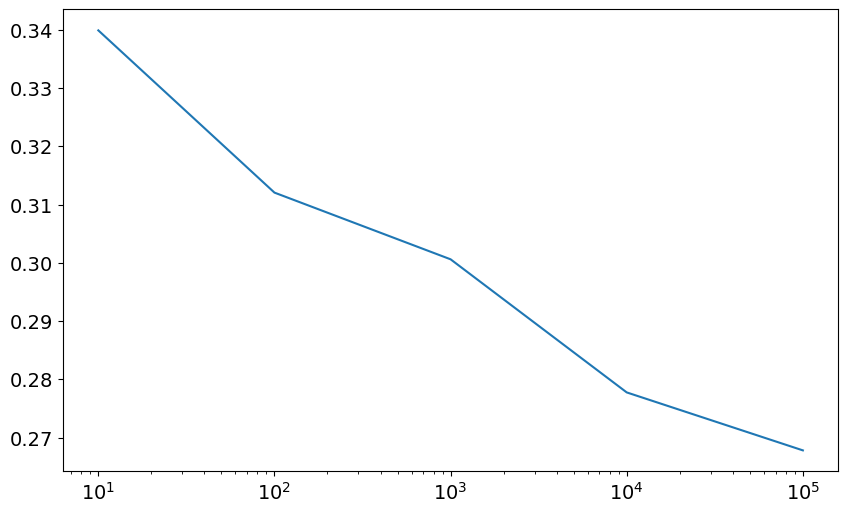

In [69]:
plt.plot(threshold_list, np.array(threshold_counts)/len(bb_subset))
plt.xscale('log')

In [70]:
aa, bb2 = parity_temp_display(temp_data, attrs, active_reset=False, threshold = readout_threshold, readouts_per_rep= readouts_per_rep, 
                             cutoff_meas_idx=60)
bb2_subset = bb2[0:20000]
threshold_counts2, m1_running_dict = compute_threshold_counts(bb2_subset, threshold_list, T = T, E = E)


Processing: 100%|██████████| 20000/20000 [16:04<00:00, 20.73it/s]


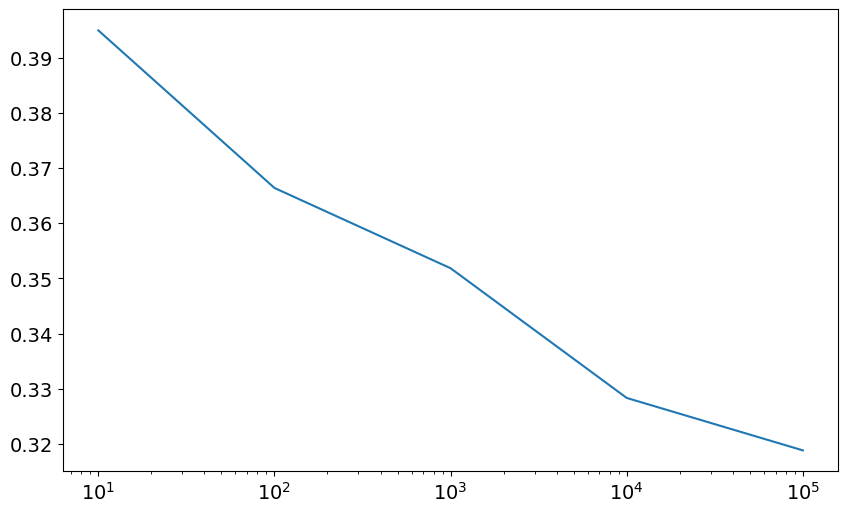

In [71]:
plt.plot(threshold_list, np.array(threshold_counts2)/len(bb2_subset))
plt.xscale('log')

In [72]:
threshold_counts2

[7899, 7328, 7037, 6567, 6377]

In [75]:
0.014 /0.4

0.034999999999999996

In [73]:
threshold_counts

[6798, 6241, 6012, 5555, 5356]

## Manipulate 2

In [96]:
temp_data, attrs = prev_data(expt_path, '00013_ParityTempExperiment.h5')
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = -63.47477176210509, readouts_per_rep=80)

In [109]:
ii = 2
temp_meas_sequence = meas_sequence[0:ii+1]
    
# forward-backward algorithm return state probabilities at each step
gamma_matrix, alpha, beta = gamma(temp_meas_sequence, T, E, ret_all = False)

# pick off probability of cavitiy state at the beginning, 0 in the first index
# # sum over qubit state probability, second index
# P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
# P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])

# gamma_matrix

In [110]:
meas_sequence = bb[5000]

# want to compute the probabilities of 0 or 1 photon initially in the cavity
P0_first = []
P1_first = []

# iteratively calculate probabilities using one additional measurement at a time
# observe how probabilities 'evolve' with more meaurements in the recrod
for ii in range (len(meas_sequence)):
    
    # analyze subeset of measurment record from beginning to ii-th measuement
    # could be implemented online to do feedback in the measurement
    temp_meas_sequence = meas_sequence[0:ii+1]
    
    # forward-backward algorithm return state probabilities at each step
    # gamma_matrix = gamma(temp_meas_sequence, T, E)
    
    # # pick off probability of cavitiy state at the beginning, 0 in the first index
    # # sum over qubit state probability, second index
    # P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
    # P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])

    gamma_first_row = wrapper_gamma(temp_meas_sequence, running_dict = {'meas_sequence':[], 'gamma_first_row':[]})
    P0_first.append(gamma_first_row[0] + gamma_first_row[1])
    P1_first.append(gamma_first_row[2] + gamma_first_row[3])
# figure(figsize = (12,8))

# # plot measurement record
# subplot(2,1,1)
# plot(meas_sequence, 'o--')
# ylim(-0.1, 1.1)

# # plot reconstructed probabilities for subsets of the measurement record
# subplot(2,1,2)
# semilogy(P0_first, 'o', label= "P(n=0)")
# semilogy(P1_first, 'o', label= "P(n=1)")
# #         axhline(1e-9)
# #         plot(P0_first, 'o', label= "P(n=0)")
# #         plot(P1_first, 'o', label= "P(n=1)")
# #         axhline(1e-8)
# #         ylim(1e-16,1e0)
# ylabel('P(t=0)')
# xlabel('Number of Parity Measurements Included')
# legend()
# tight_layout

In [987]:
temp_data, attrs = prev_data(expt_path, '00012_ParityTempExperiment.h5')
threshold_list = [10]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = -88.47477176210509, readouts_per_rep=40)
threshold_counts, running_dict = compute_threshold_counts(bb, threshold_list)
orig_running_dict = running_dict.copy()

Processing: 100%|██████████| 100000/100000 [05:20<00:00, 311.63it/s]


In [ ]:
full_threshold_list =[100.0,
 1000.0,
 10000.0,
 100000.0,
 10000000.0,
 100000000.0,
 1000000000.0,
 10000000000.0,
 100000000000.0,
 1000000000000.0,
 10000000000000.0,
 100000000000000.0,
 1000000000000000.0,
 1e+16,
 1e+17,
 1e+18,
 1e+19,
 1e+20,
 1e+21,
 1e+23,
 1e+25,
 1e+27,
 1e+30,
 1e+35,
 1e+40,
 1e+45,
 1e+50]
threshold_counts, running_dict = compute_threshold_counts(bb, full_threshold_list, orig_running_dict)

# reorder full threshold list so its lowest to highest and threshold counts are in the same order
full_threshold_list, threshold_counts = zip(*sorted(zip(full_threshold_list, threshold_counts)))

Processing:  55%|█████▍    | 54670/100000 [36:25<33:26, 22.59it/s]  

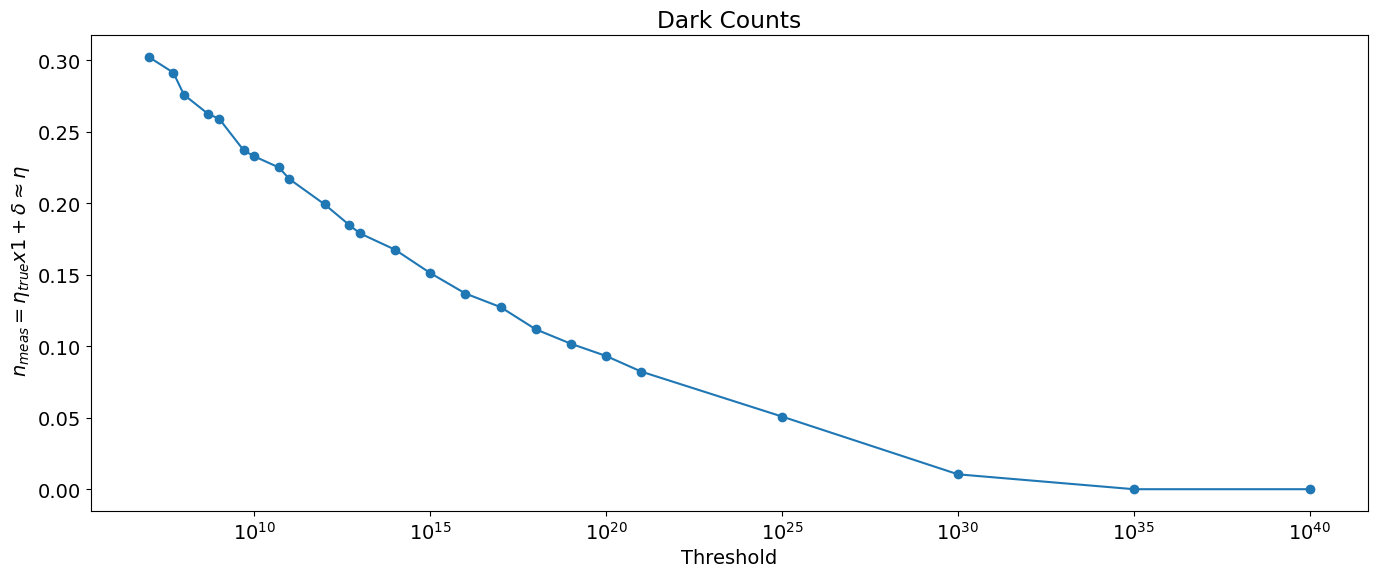

In [989]:
dark_counts = np.array(threshold_counts) / 1e5

thermal_photon_population = []
# for i in range(len(dark_counts)):
#     thermal_photon_population.append(dark_counts[i] / efficiency_list[i])



# Create subplots
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 6))

# Plot thermal photon population
ax1.plot(full_threshold_list, dark_counts, 'o-')
ax1.set_xscale('log')
ax1.set_xlabel('Threshold')
ax1.set_ylabel(r' $n_{meas} = \eta_{true} x 1 + \delta \approx \eta$')
ax1.set_title('Dark Counts')


# plt.suptitle(str('M1') + ' Thermal Photon Population Temperature vs. Threshold')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


## Manipulate 1

### Testing whether probablities of sequences are correct

In [1002]:
sequence =[0,1,0,1,0,1]
gamma_first_row = wrapper_gamma(sequence, running_dict = {'meas_sequence':[], 'gamma_first_row':[]})
P0 = gamma_first_row[0] + gamma_first_row[1]
P1 = gamma_first_row[2] + gamma_first_row[3]

# orint probabilities of 0 and 1 photons in the cavity
print('P0: ', P0)
print('P1: ', P1)


P0:  2.7929897975595212e-05
P1:  0.9999720701020245


### Efficiency (prepare|1>, perform measurements)

In [1074]:
temp_data, attrs = prev_data(expt_path, '00124_cavity_temperature_sweep_parity_with_without_reset.h5')
# temp_data, attrs = prev_data(expt_path, '00056_cavity_temperature_sweep_parity_with_without_reset.h5')
threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number']
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = threshold, readouts_per_rep= readouts_per_rep)

In [1075]:
attrs['config']

{'prepulse_qubit': {'freq': [3568.1751638611518],
  'length': [0.06],
  'gain': [30],
  'phase': [0],
  'repeat_time': 10},
 'device': {'qubit': {'T1': [127.0],
   'f_ge': [3568.1515953227604],
   'f_ge_resolved': [3568.1515953227604],
   'f_ge_idle': [3568.1515953227604],
   'f_ef': [3425.5564066067],
   'f_ef_idle': [3425.5564066067],
   'ramp_sigma': [0.005],
   'ramp_sigma_num': [3],
   'pulses': {'pi_ge': {'gain': [10716],
     'sigma': [0.035],
     'length': [0],
     'type': ['gauss']},
    'pi_ge_ftop': {'gain': [3000],
     'sigma': [0.005],
     'length': [0.190914187445986],
     'type': ['flat_top']},
    'pi_ge_fast': {'gain': [10682],
     'sigma': [0.035],
     'length': [0],
     'type': ['gauss']},
    'pi_ge_resolved': {'gain': [50],
     'sigma': [0.005],
     'length': [6.553697146578866],
     'type': ['flat_top'],
     'repeat_no': [1]},
    'hpi_ge': {'gain': [5510],
     'length': [0],
     'sigma': [0.035],
     'type': ['gauss']},
    'hpi_ge_ftop': {'gain': 

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

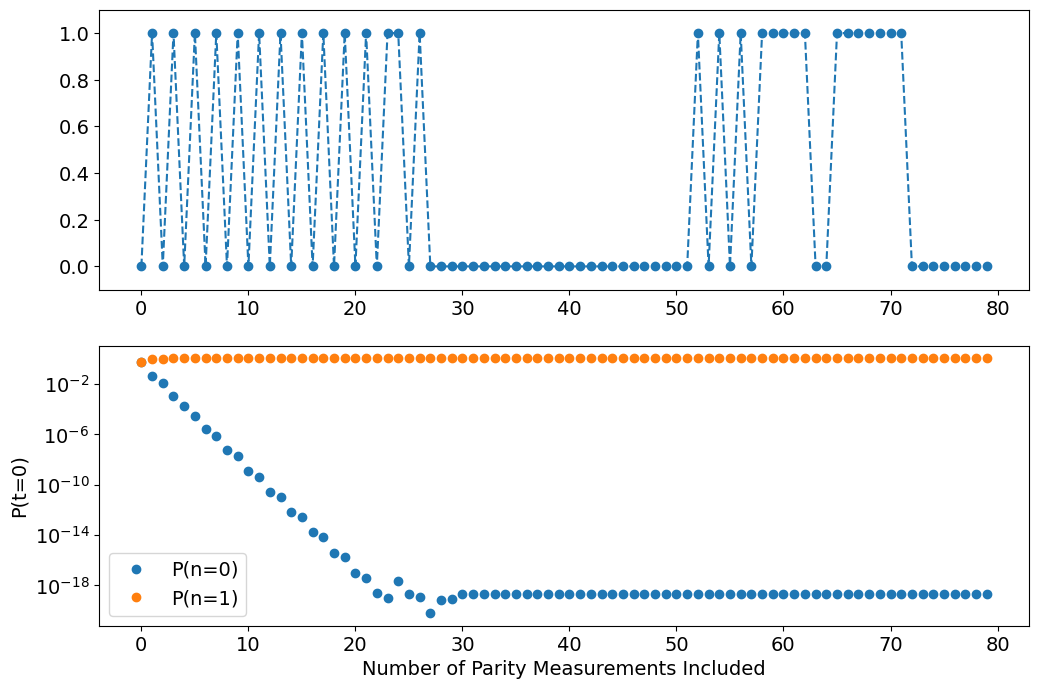

In [1013]:
meas_sequence = bb[20000 -1]

# want to compute the probabilities of 0 or 1 photon initially in the cavity
P0_first = []
P1_first = []

# iteratively calculate probabilities using one additional measurement at a time
# observe how probabilities 'evolve' with more meaurements in the recrod
for ii in range (len(meas_sequence)):
    
    # analyze subeset of measurment record from beginning to ii-th measuement
    # could be implemented online to do feedback in the measurement
    temp_meas_sequence = meas_sequence[0:ii+1]
    
    # forward-backward algorithm return state probabilities at each step
    # gamma_matrix = gamma(temp_meas_sequence, T, E)
    
    # # pick off probability of cavitiy state at the beginning, 0 in the first index
    # # sum over qubit state probability, second index
    # P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
    # P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])

    gamma_first_row = wrapper_gamma(temp_meas_sequence, running_dict = {'meas_sequence':[], 'gamma_first_row':[]})
    P0_first.append(gamma_first_row[0] + gamma_first_row[1])
    P1_first.append(gamma_first_row[2] + gamma_first_row[3])
figure(figsize = (12,8))

# plot measurement record
subplot(2,1,1)
plot(meas_sequence, 'o--')
ylim(-0.1, 1.1)

# plot reconstructed probabilities for subsets of the measurement record
subplot(2,1,2)
semilogy(P0_first, 'o', label= "P(n=0)")
semilogy(P1_first, 'o', label= "P(n=1)")
#         axhline(1e-9)
#         plot(P0_first, 'o', label= "P(n=0)")
#         plot(P1_first, 'o', label= "P(n=1)")
#         axhline(1e-8)
#         ylim(1e-16,1e0)
ylabel('P(t=0)')
xlabel('Number of Parity Measurements Included')
legend()
tight_layout

In [533]:
# plot the function: efficiency vs threshold
threshold_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]
counts_list = []
for threshold in threshold_list:
    print('calculating threshold:', threshold)
    counts = 0
    for i in range(len(bb)):
        gamma_matrix = gamma(bb[i], T, E)

        P0 = gamma_matrix[0,0] + gamma_matrix[0,1]
        P1 = gamma_matrix[0,2] + gamma_matrix[0,3]

        # Compare the probabilities of the two models to obtain a likelihood ratio
        likelihood_ratio = P1/P0   
        if likelihood_ratio > threshold:
            counts += 1
    counts_list.append(counts)
print(counts_list)

calculating threshold: 10
calculating threshold: 50
calculating threshold: 100
calculating threshold: 500
calculating threshold: 1000
calculating threshold: 5000
calculating threshold: 10000
calculating threshold: 50000
calculating threshold: 100000
[12737, 12067, 11894, 11596, 11379, 10836, 10765, 10240, 10092]


Text(0.5, 1.0, 'M1=|1>')

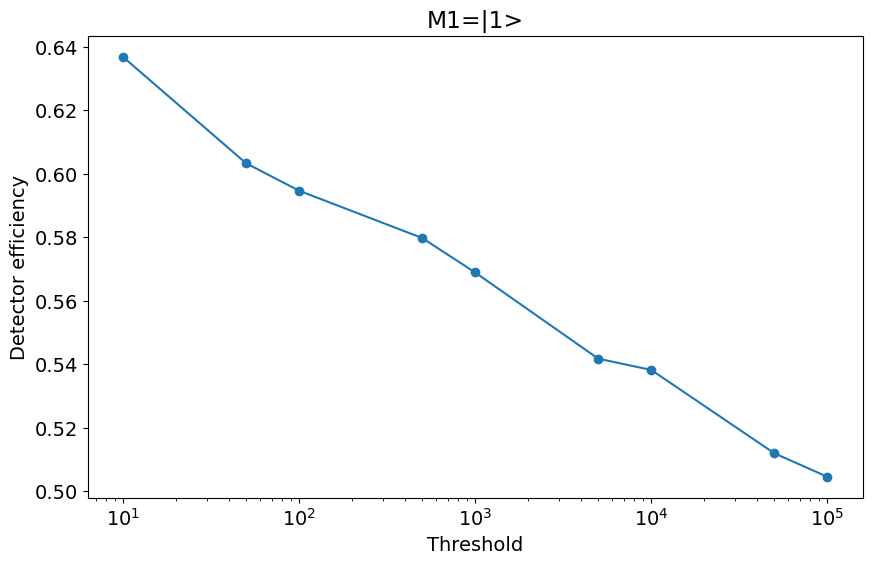

In [534]:
plt.plot(threshold_list, np.array(counts_list)/len(bb), 'o-')
plt.xscale('log')
plt.xlabel('Threshold')
plt.ylabel('Detector efficiency')
plt.title('M1=|1>')

### Actual Dark counts

In [546]:
temp_data, attrs = prev_data(expt_path, '00007_ParityTempExperiment.h5')
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = -63.47477176210509, readouts_per_rep=40)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

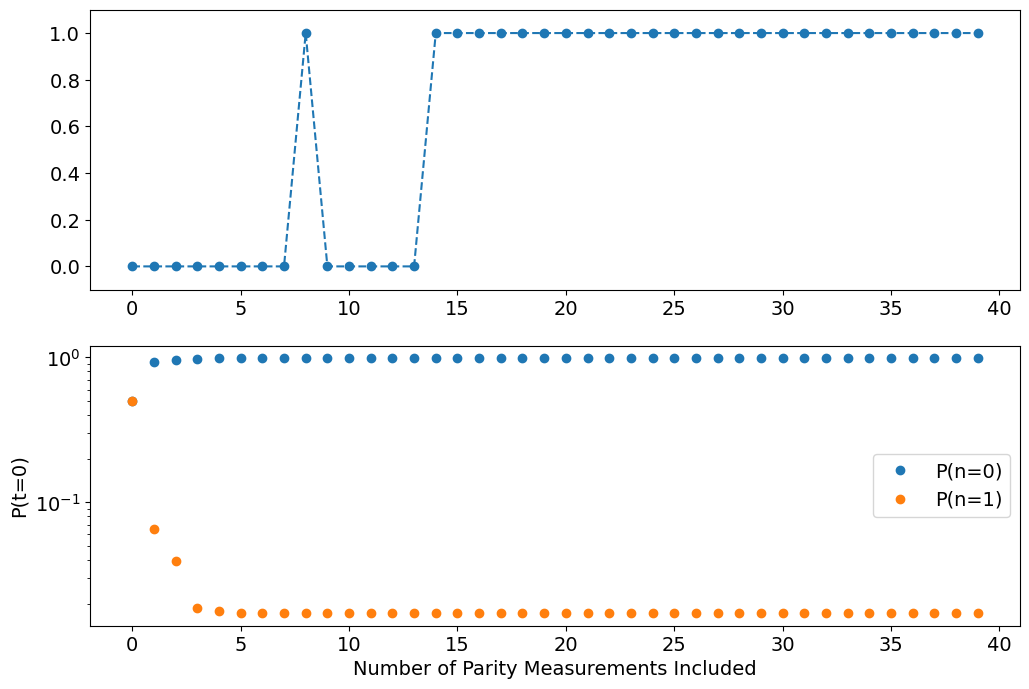

In [547]:
meas_sequence = bb[1600]

# want to compute the probabilities of 0 or 1 photon initially in the cavity
P0_first = []
P1_first = []

# iteratively calculate probabilities using one additional measurement at a time
# observe how probabilities 'evolve' with more meaurements in the recrod
for ii in range (len(meas_sequence)):
    
    # analyze subeset of measurment record from beginning to ii-th measuement
    # could be implemented online to do feedback in the measurement
    temp_meas_sequence = meas_sequence[0:ii+1]
    
    # forward-backward algorithm return state probabilities at each step
    gamma_matrix = gamma(temp_meas_sequence, T, E)
    
    # pick off probability of cavitiy state at the beginning, 0 in the first index
    # sum over qubit state probability, second index
    P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
    P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])

figure(figsize = (12,8))

# plot measurement record
subplot(2,1,1)
plot(meas_sequence, 'o--')
ylim(-0.1, 1.1)

# plot reconstructed probabilities for subsets of the measurement record
subplot(2,1,2)
semilogy(P0_first, 'o', label= "P(n=0)")
semilogy(P1_first, 'o', label= "P(n=1)")
#         axhline(1e-9)
#         plot(P0_first, 'o', label= "P(n=0)")
#         plot(P1_first, 'o', label= "P(n=1)")
#         axhline(1e-8)
#         ylim(1e-16,1e0)
ylabel('P(t=0)')
xlabel('Number of Parity Measurements Included')
legend()
tight_layout

In [538]:
# plot the function: efficiency vs threshold
threshold_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]
efficiency_list = np.array([12737, 12067, 11894, 11596, 11379, 10836, 10765, 10240, 10092])/20000
counts_list = []
for threshold in threshold_list:
    print('calculating threshold:', threshold)
    counts = 0
    for i in range(len(bb)):
        gamma_matrix = gamma(bb[i], T, E)

        P0 = gamma_matrix[0,0] + gamma_matrix[0,1]
        P1 = gamma_matrix[0,2] + gamma_matrix[0,3]

        # Compare the probabilities of the two models to obtain a likelihood ratio
        likelihood_ratio = P1/P0   
        if likelihood_ratio > threshold:
            counts += 1
    counts_list.append(counts)
print(counts_list)

calculating threshold: 10
calculating threshold: 50
calculating threshold: 100
calculating threshold: 500
calculating threshold: 1000
calculating threshold: 5000
calculating threshold: 10000
calculating threshold: 50000
calculating threshold: 100000
[157, 131, 127, 117, 117, 104, 104, 89, 88]


Text(0.5, 1.0, 'Dark photon')

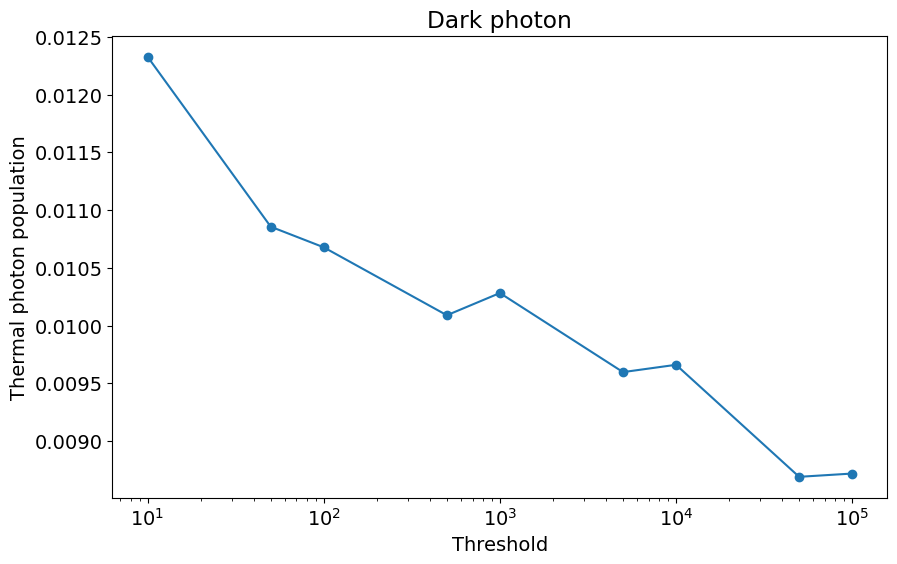

In [539]:
dark_counts = np.array([157, 131, 127, 117, 117, 104, 104, 89, 88])/20000

thermal_photon_population = []
for i in range(len(dark_counts)):
    thermal_photon_population.append(dark_counts[i]/efficiency_list[i])

plt.plot(threshold_list, thermal_photon_population, 'o-')
plt.xscale('log')
plt.xlabel('Threshold')
plt.ylabel('Thermal photon population')
plt.title('Dark photon')

Text(0, 0.5, 'M1 Temperature (mK)')

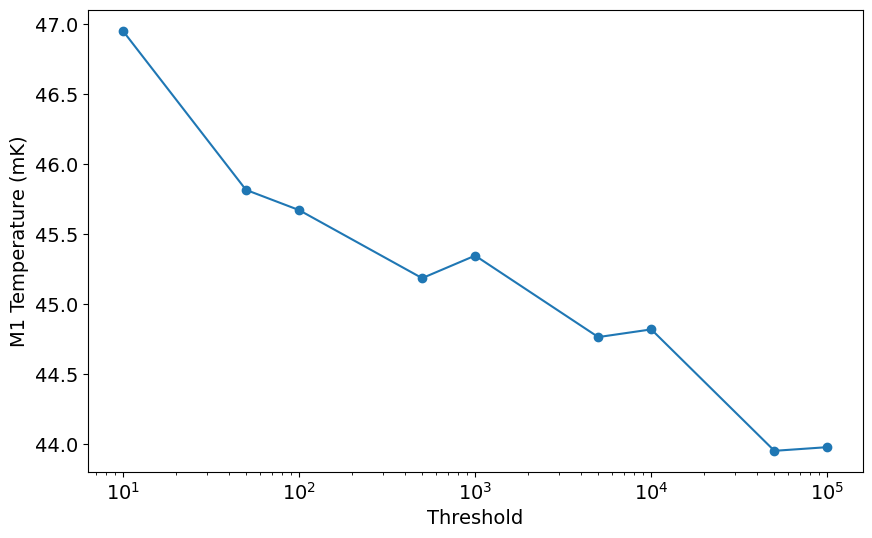

In [545]:
freq = 4.984
now = np.array(thermal_photon_population)/2
tempr = []
for i in range(len(now)):
    tempr.append(48*freq/(np.log(1+1/now[i])))
plt.plot(threshold_list, tempr, 'o-')
plt.xscale('log')
plt.xlabel('Threshold')
plt.ylabel('M1 Temperature (mK)')

In [548]:
# plot the function: efficiency vs threshold
threshold_list = [100000]
efficiency_list = np.array([10092])/20000
counts_list = []
for threshold in threshold_list:
    print('calculating threshold:', threshold)
    counts = 0
    for i in range(len(bb)):
        gamma_matrix = gamma(bb[i], T, E)

        P0 = gamma_matrix[0,0] + gamma_matrix[0,1]
        P1 = gamma_matrix[0,2] + gamma_matrix[0,3]

        # Compare the probabilities of the two models to obtain a likelihood ratio
        likelihood_ratio = P1/P0   
        if likelihood_ratio > threshold:
            counts += 1
    counts_list.append(counts)
print(counts_list)

calculating threshold: 100000
[401]


In [549]:
dark_counts = np.array([401])/100000

thermal_photon_population = []
for i in range(len(dark_counts)):
    thermal_photon_population.append(dark_counts[i]/efficiency_list[-1])

In [551]:
freq = 4.984
now = np.array(thermal_photon_population)/2
tempr = []
for i in range(len(now)):
    tempr.append(48*freq/(np.log(1+1/now[i])))
print(tempr)

[43.24443494250535]


## Storage without Active Reset


### Calculate Efficiency

In [27]:
# temp_data, attrs = prev_data(expt_path, '00056_cavity_temperature_sweep_parity_with_without_reset.h5')
temp_data, attrs = prev_data(expt_path, '00110_cavity_temperature_sweep_parity_with_without_reset.h5')
# temp_data, attrs = prev_data(expt_path, '00011_ParityTempExperiment.h5')

threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number']
threshold_list = [10]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = threshold, readouts_per_rep= readouts_per_rep)
# threshold_counts, running_dict = compute_threshold_counts(bb, threshold_list)
# orig_running_dict = running_dict.copy()

In [16]:
attrs['config']

{'prepulse_qubit': {'freq': [3568.1751638611518],
  'length': [0.06],
  'gain': [30],
  'phase': [0],
  'repeat_time': 10},
 'device': {'qubit': {'T1': [127.0],
   'f_ge': [3568.1515953227604],
   'f_ge_resolved': [3568.1515953227604],
   'f_ge_idle': [3568.1515953227604],
   'f_ef': [3425.5564066067],
   'f_ef_idle': [3425.5564066067],
   'ramp_sigma': [0.005],
   'ramp_sigma_num': [3],
   'pulses': {'pi_ge': {'gain': [10716],
     'sigma': [0.035],
     'length': [0],
     'type': ['gauss']},
    'pi_ge_ftop': {'gain': [3000],
     'sigma': [0.005],
     'length': [0.190914187445986],
     'type': ['flat_top']},
    'pi_ge_fast': {'gain': [10682],
     'sigma': [0.035],
     'length': [0],
     'type': ['gauss']},
    'pi_ge_resolved': {'gain': [50],
     'sigma': [0.005],
     'length': [6.553697146578866],
     'type': ['flat_top'],
     'repeat_no': [1]},
    'hpi_ge': {'gain': [5510],
     'length': [0],
     'sigma': [0.035],
     'type': ['gauss']},
    'hpi_ge_ftop': {'gain': 

In [28]:
full_threshold_list = [  1e2, 1e3, 1e4, 1e5, 1e7, 1e8, 1e9,  1e10,   1e11,   1e12, 1e13, 1e14, 1e15, 1e16, 1e17, 1e18, 1e19, 1e20, 1e21, 1e23, 1e25, 1e27, 1e30, 1e35, 1e40, 1e45, 1e50]
threshold_counts, running_dict = compute_threshold_counts(bb, full_threshold_list, orig_running_dict)

Processing: 100%|██████████| 200000/200000 [44:03<00:00, 75.67it/s] 


In [29]:
threshold_counts

[87849,
 85081,
 80145,
 77923,
 69796,
 67270,
 63299,
 61546,
 57782,
 56067,
 52828,
 50320,
 48423,
 45709,
 44360,
 41734,
 40287,
 38129,
 36227,
 32870,
 29905,
 27192,
 23475,
 18495,
 14353,
 11046,
 8310]

In [30]:
# reorder full threshold list so its lowest to highest and threshold counts are in the same order
full_threshold_list, threshold_counts = zip(*sorted(zip(full_threshold_list, threshold_counts)))

In [8]:
dicty = {'keys':[], 'values':[]}

n =20000
for i in range(n):
    # express i in binary with 80 digits
    binary = format(i, '080b')
    dicty['keys'].append(binary)
    dicty['values'].append(1)



In [12]:
string =  format(10000, '080b')
if string in dicty['keys']:
    print('yes')

yes


In [7]:
format(20000, '080b')

'00000000000000000000000000000000000000000000000000000000000000000100111000100000'

#### Looking at maximal attainable threshold

In [1014]:
temp_data, attrs = prev_data(expt_path, '00056_cavity_temperature_sweep_parity_with_without_reset.h5')
threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number']
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = threshold, readouts_per_rep= readouts_per_rep)

In [72]:

full_meas_sequence = bb[1000]

def find_probs_for_sequence(full_meas_sequence):
    '''
    Given a measurement record, compute the probabilities of 0 or 1 photon initially for each subset of the record
    '''
    P0_list = []
    P1_list = []
    for ii in range (len(full_meas_sequence)):
        meas_sequence = full_meas_sequence[0:ii + 1]
        gamma_first_row = wrapper_gamma(meas_sequence, running_dict = {'meas_sequence':[], 'gamma_first_row':[]})
        P0 = gamma_first_row[0] + gamma_first_row[1]
        P1 = gamma_first_row[2] + gamma_first_row[3]
        P0_list.append(P0)
        P1_list.append(P1)
    return P0_list, P1_list

P0_list, P1_list = find_probs_for_sequence(full_meas_sequence)
    

# # plot the P0 and P1 probabilities
# figure(figsize = (12,8))

# # plot measurement record
# subplot(2,1,1)
# plot(meas_sequence, 'o--')
# ylim(-0.1, 1.1)

# # plot reconstructed probabilities for subsets of the measurement record
# subplot(2,1,2)
# semilogy(P0_list, 'o', label= "P(n=0)")
# semilogy(P1_list, 'o', label= "P(n=1)")
# #         axhline(1e-9)
# #         plot(P0_first, 'o', label= "P(n=0)")
# #         plot(P1_first, 'o', label= "P(n=1)")
# #         axhline(1e-8)
# #         ylim(1e-16,1e0)
# ylabel('P(t=0)')
# xlabel('Number of Parity Measurements Included')
# title('Looking at a measurement sequence to get max threshold')
# legend()
# tight_layout

0it [00:00, ?it/s]C:\Users\26049\AppData\Local\Temp\ipykernel_24012\3479883377.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("winter")
3it [00:06,  2.09s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

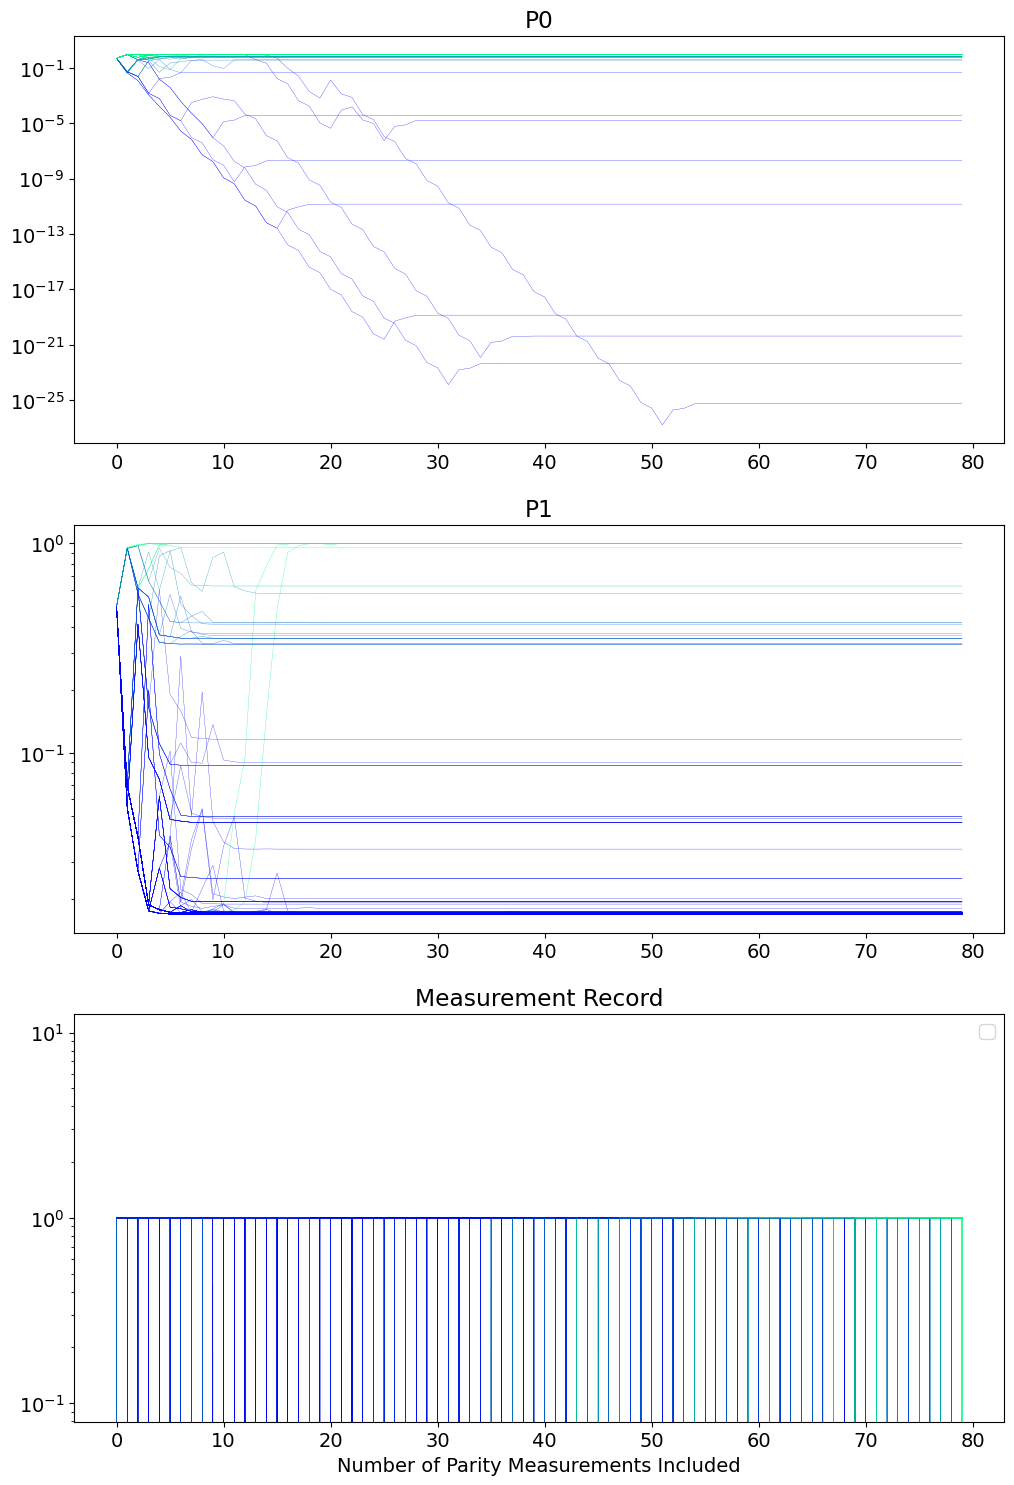

In [1018]:
temp_data, attrs = prev_data(expt_path, '00058_cavity_temperature_sweep_parity_with_without_reset.h5')
threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number']
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = threshold, readouts_per_rep= readouts_per_rep)

meas_sequences = bb[0:20000: 20]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

P1_lists = []
P0_lists = []

for meas_sequence in meas_sequences:
    P0_list, P1_list = find_probs_for_sequence(meas_sequence)
    P0_lists.append(P0_list)
    P1_lists.append(P1_list)

# P0_lists, P1_lists = find_probs_for_sequence(meas_sequences)

xlists = [P0_lists, P1_lists, meas_sequences]
axs = [ax1, ax2, ax3]
titles = ['P0', 'P1', 'Measurement Record']
mins = [1e-20, 1e-5, 0 ]

for xlist, ax, title, min_ in tqdm(zip(xlists, axs, titles, mins)):
    for x in xlist:
        norm = matplotlib.colors.Normalize(
            vmin=min_, vmax=1
        )
        cmap = matplotlib.cm.get_cmap("winter")
        color = cmap(norm(x[-1]))
        ax.semilogy(
            x, "-", linewidth=0.2, alpha=1, color=color
        )
        ax.set_title(title)      

#ylabel('P(t=0)')
xlabel('Number of Parity Measurements Included')
#title('Looking at a measurement sequence to get max threshold')
legend()
tight_layout

In [ ]:
def plot_fidelities(self, timestamp=None, fig=None, ax=None, log=True, **kwargs):
        fidelities = self.fidelities(timestamp).T
        fig = fig if fig is not None else plt.figure(figsize=(3.5, 2.25), dpi=200)
        ax = ax if ax is not None else fig.subplots()
        end_fids = fidelities[:, -1]
        indxs = np.argsort(end_fids)
        fidelities = fidelities[indxs]
        for fids in fidelities[:-1]:
            import matplotlib

            norm = matplotlib.colors.Normalize(
                vmin=np.log10(1 - fidelities[-1][-1]), vmax=0
            )
            cmap = matplotlib.cm.get_cmap("winter")
            color = cmap(norm(np.log10(1 - fids[-1])))
            if log:
                ax.semilogy(
                    1 - fids, "-", linewidth=0.2, alpha=1, color=color, **kwargs
                )
            else:
                ax.plot(fids, "-", linewidth=0.5, **kwargs)
        color = cmap(norm(np.log10(1 - fidelities[-1][-1])))
        if log:
            ax.semilogy(1 - fidelities[-1], linewidth=1, color=color, **kwargs)
        else:
            ax.plot(fidelities[-1], **kwargs)

        # ax.set_xlabel("epoch", size=8)
        # if log:
        #    ax.set_ylabel("infidelity", size=8)
        # else:
        #    ax.set_ylabel("fidelity", size=8)
        fig.tight_layout()

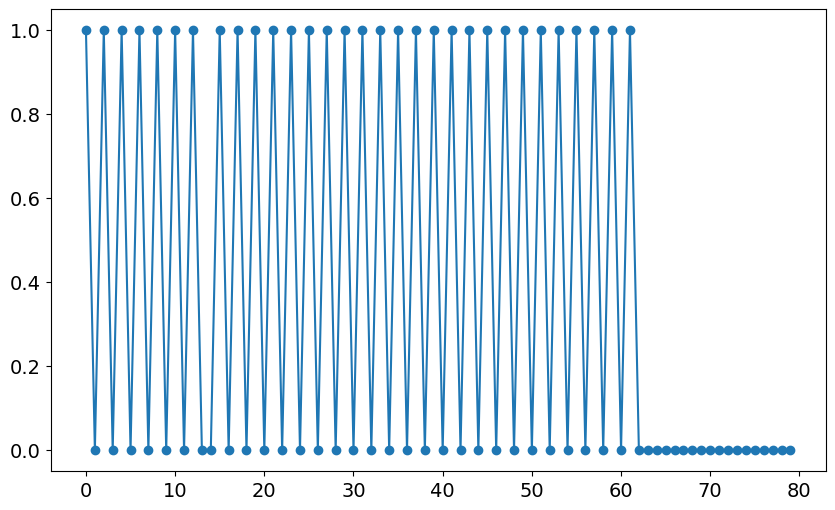

In [93]:
plt.plot(meas_sequences[200], '-o')

In [94]:
meas_sequences[200]

[1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

#### Now computing efficiency

In [31]:
attrs['config']['expt'] 

{'start': 0.01,
 'step': 1,
 'expts': 1,
 'parity_number': 80,
 'ramsey_freq': 0.0,
 'reps': 200000,
 'rounds': 1,
 'qubits': [0],
 'user_defined_freq': [False, 3425.30098176373, 7575, 0.035],
 'normalize': False,
 'active_reset': False,
 'man_reset': True,
 'storage_reset': True,
 'man_no': 1,
 'prepulse': True,
 'pre_sweep_pulse': [[3568.1515953227604, 3425.5564066067, 2007.0],
  [10716, 8236, 15000],
  [0, 0, 0.6056817916987671],
  [0, 0, 0],
  [2, 2, 0],
  ['g', 'g', 'flat_top'],
  [0.035, 0.035, 0.005]],
 'readout_no_placeholder': 80}

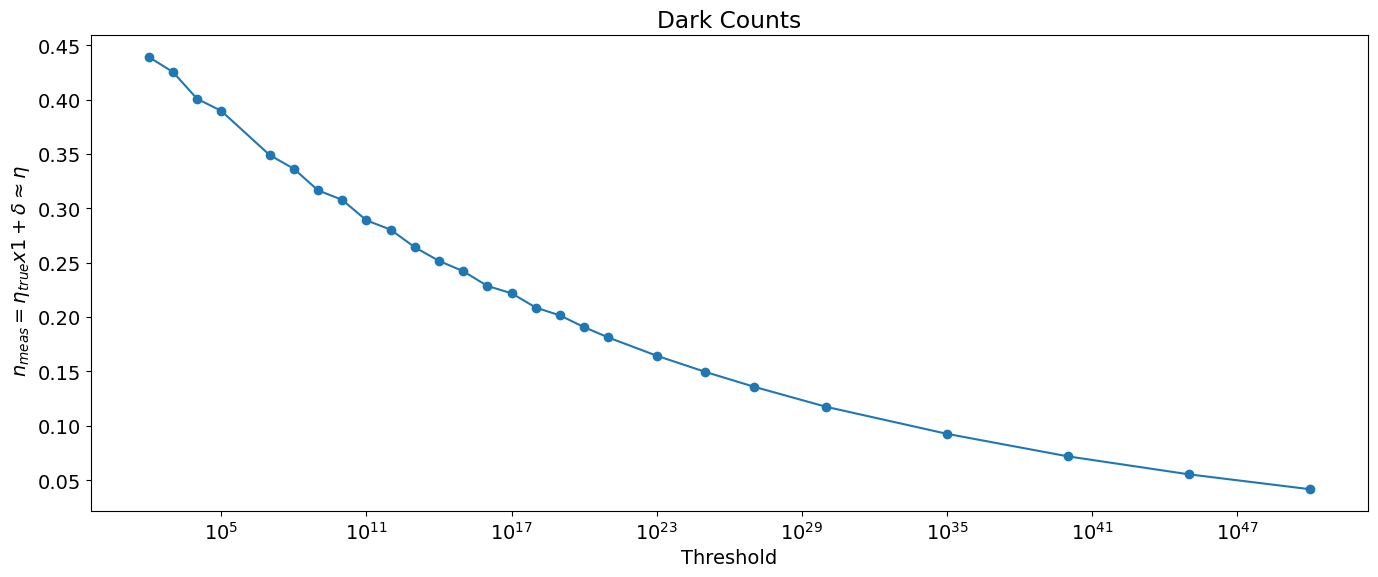

In [32]:
n = attrs['config']['expt']['reps']
dark_counts = np.array(threshold_counts) / n

thermal_photon_population = []
# for i in range(len(dark_counts)):
#     thermal_photon_population.append(dark_counts[i] / efficiency_list[i])



# Create subplots
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 6))

# Plot thermal photon population
ax1.plot(full_threshold_list, dark_counts, 'o-')
ax1.set_xscale('log')
ax1.set_xlabel('Threshold')
ax1.set_ylabel(r' $n_{meas} = \eta_{true} x 1 + \delta \approx \eta$')
ax1.set_title('Dark Counts')


# plt.suptitle(str('M1') + ' Thermal Photon Population Temperature vs. Threshold')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [33]:
efficiency_list = np.array(threshold_counts) /attrs['config']['expt']['reps']

In [34]:
efficiency_list 

array([0.439245, 0.425405, 0.400725, 0.389615, 0.34898 , 0.33635 ,
       0.316495, 0.30773 , 0.28891 , 0.280335, 0.26414 , 0.2516  ,
       0.242115, 0.228545, 0.2218  , 0.20867 , 0.201435, 0.190645,
       0.181135, 0.16435 , 0.149525, 0.13596 , 0.117375, 0.092475,
       0.071765, 0.05523 , 0.04155 ])

Text(0, 0.5, 'Dark Counts')

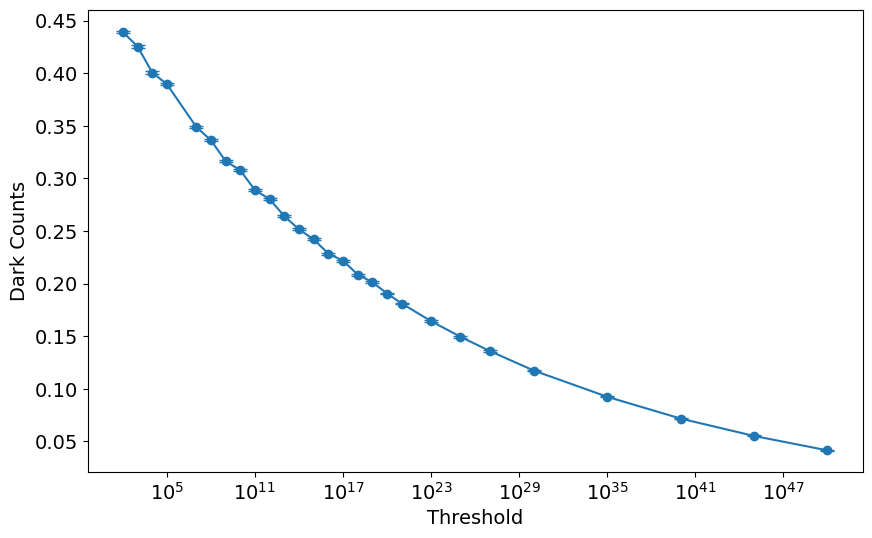

In [35]:
dark_counts =  efficiency_list
# standard error from binomial distribution sqrt(p(1-p)/n)
probs = efficiency_list 
n = attrs['config']['expt']['reps']
efficiency_list_err = np.sqrt(probs*(1-probs)/n)
# dark_counts_err = np.sqrt(dark_counts )
# efficiency_list_err = dark_counts_err/1e5

# plt.errorbar(full_threshold_list, dark_counts, yerr=dark_counts_err, fmt='o-', capsize=5)
plt.errorbar(full_threshold_list, efficiency_list, yerr=efficiency_list_err, fmt='o-', capsize=5)
plt.xscale('log')
plt.xlabel('Threshold')
plt.ylabel('Dark Counts')

In [36]:
efficiency_list_err

array([0.00110975, 0.00110552, 0.00109577, 0.00109045, 0.00106582,
       0.00105645, 0.00104001, 0.00103207, 0.00101351, 0.00100436,
       0.00098582, 0.0009703 , 0.00095785, 0.00093891, 0.00092899,
       0.00090864, 0.00089682, 0.00087835, 0.00086118, 0.00082867,
       0.00079739, 0.0007664 , 0.00071972, 0.00064778, 0.00057713,
       0.00051078, 0.00044623])

In [831]:
# efficiency_list = [0.6611 , 0.63235, 0.62515, 0.61114, 0.60217, 0.57661, 0.57405,
#        0.54543, 0.53883, 0.49583, 0.49091, 0.4786 , 0.46403, 0.45069,
#        0.44733]

### Use above efficiency to calculate temperature for M1
This is really the efficiency-normalized false positive  probability for M1

In [79]:
# temp_data, attrs = prev_data(expt_path, '00112_cavity_temperature_sweep_parity_with_without_reset.h5')
temp_data, attrs = prev_data(expt_path, '00015_ParityTempExperiment.h5')
threshold = attrs['config']['device']['readout']['threshold'][0]
readouts_per_rep = attrs['config']['expt']['parity_number']
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = threshold, readouts_per_rep= readouts_per_rep)

threshold_counts, m1_running_dict = compute_threshold_counts(bb, full_threshold_list)#, m1_running_dict)


Processing:   0%|          | 0/100000 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'shape'

#### Measurement record analsysi

C:\Users\26049\AppData\Local\Temp\ipykernel_24012\1498363134.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("winter")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

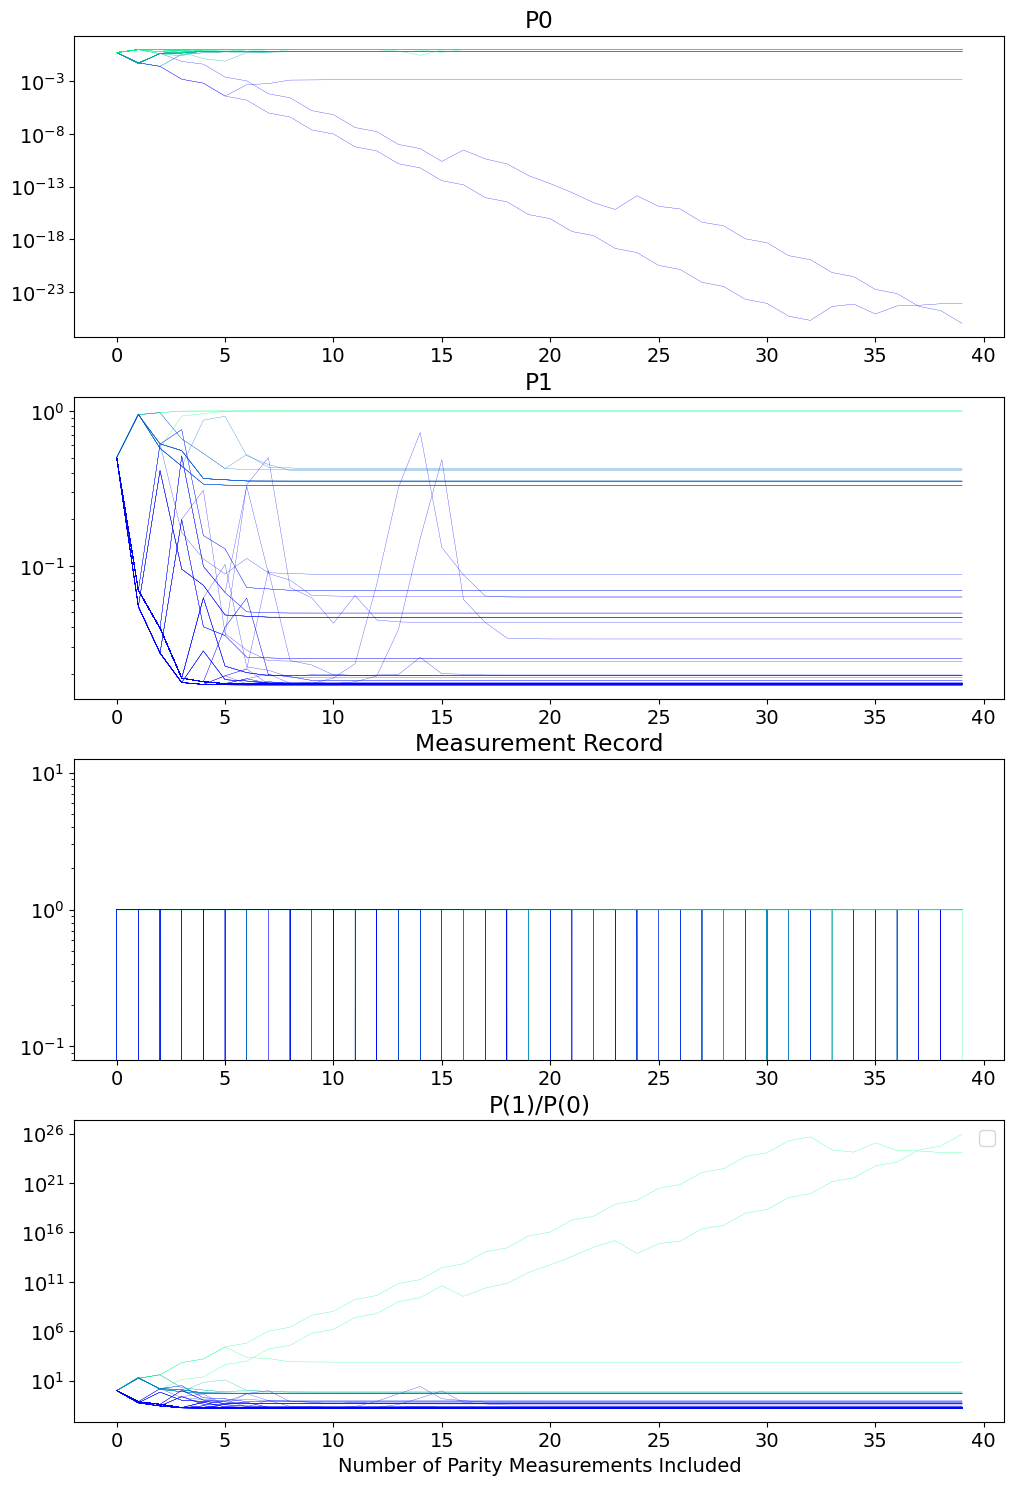

In [964]:
temp_data, attrs = prev_data(expt_path, '00008_cavity_temperature_sweep_parity.h5')
# threshold = attrs['config']['device']['readout']['threshold'][0]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = attrs['config']['device']['readout']['threshold'][0], readouts_per_rep=40)

meas_sequences = bb[0:10000: 20]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 18))

P1_lists = []
P0_lists = []

for meas_sequence in meas_sequences:
    P0_list, P1_list = find_probs_for_sequence(meas_sequence)
    P0_lists.append(P0_list)
    P1_lists.append(P1_list)

# P0_lists, P1_lists = find_probs_for_sequence(meas_sequences)

ratio_list = np.array(P1_lists) / np.array(P0_lists)

xlists = [P0_lists, P1_lists, meas_sequences, ratio_list]
axs = [ax1, ax2, ax3, ax4]
titles = ['P0', 'P1', 'Measurement Record', 'P(1)/P(0)']
mins = [1e-20, 1e-20, 0 , 1e-20]

for xlist, ax, title, min_ in zip(xlists, axs, titles, mins):
    for x in xlist:
        norm = matplotlib.colors.Normalize(
            vmin=min_, vmax=1
        )
        cmap = matplotlib.cm.get_cmap("winter")
        color = cmap(norm(x[-1]))
        ax.semilogy(
            x, "-", linewidth=0.2, alpha=1, color=color
        )
        ax.set_title(title)      

#ylabel('P(t=0)')
xlabel('Number of Parity Measurements Included')
#title('Looking at a measurement sequence to get max threshold')
legend()
tight_layout

C:\Users\26049\AppData\Local\Temp\ipykernel_5840\2593989401.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("winter")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

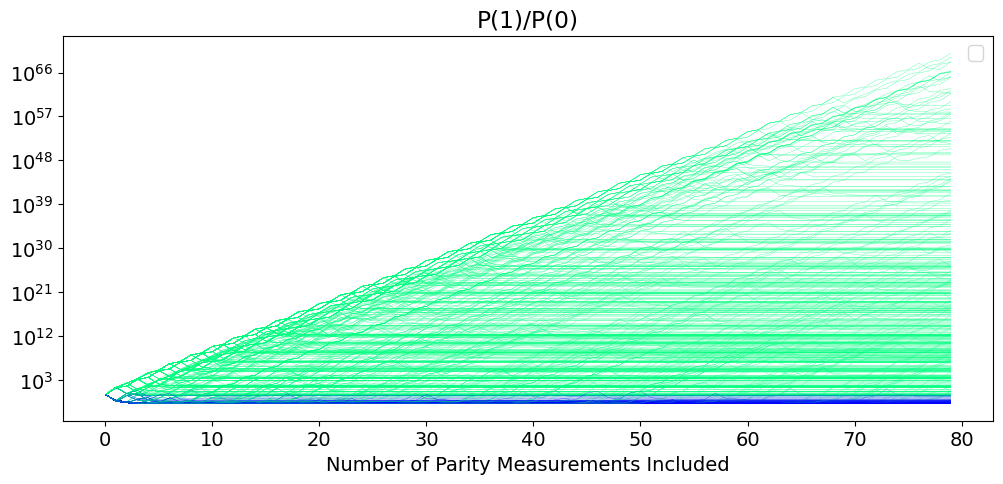

In [81]:
temp_data, attrs = prev_data(expt_path, '00110_cavity_temperature_sweep_parity_with_without_reset.h5')  # M1 dark counts
# temp_data, attrs = prev_data(expt_path, '00010_ParityTempExperiment.h5')   # efficiency
# threshold = attrs['config']['device']['readout']['threshold'][0]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = attrs['config']['device']['readout']['threshold'][0], readouts_per_rep=80)

meas_sequences = bb[0:10000: 10]

fig, (ax4) = plt.subplots(1, 1, figsize=(12, 5))

P1_lists = []
P0_lists = []

for meas_sequence in meas_sequences:
    P0_list, P1_list = find_probs_for_sequence(meas_sequence)
    P0_lists.append(P0_list)
    P1_lists.append(P1_list)

np.save('p1_lists.npy', P1_lists)
np.save('p0_lists.npy', P0_lists)

# P0_lists, P1_lists = find_probs_for_sequence(meas_sequences)

ratio_list = np.array(P1_lists) / np.array(P0_lists)

xlists = [ratio_list]
axs = [ax4]
titles = ['P(1)/P(0)']
mins = [1e-20]

for xlist, ax, title, min_ in zip(xlists, axs, titles, mins):
    for x in xlist:
        norm = matplotlib.colors.Normalize(
            vmin=min_, vmax=1
        )
        cmap = matplotlib.cm.get_cmap("winter")
        color = cmap(norm(x[-1]))
        ax.semilogy(
            x, "-", linewidth=0.2, alpha=1, color=color
        )
        ax.set_title(title)      

#ylabel('P(t=0)')
plt.xlabel('Number of Parity Measurements Included')
#title('Looking at a measurement sequence to get max threshold')
plt.legend()
plt.tight_layout

C:\Users\26049\AppData\Local\Temp\ipykernel_5840\4055057483.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("winter")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

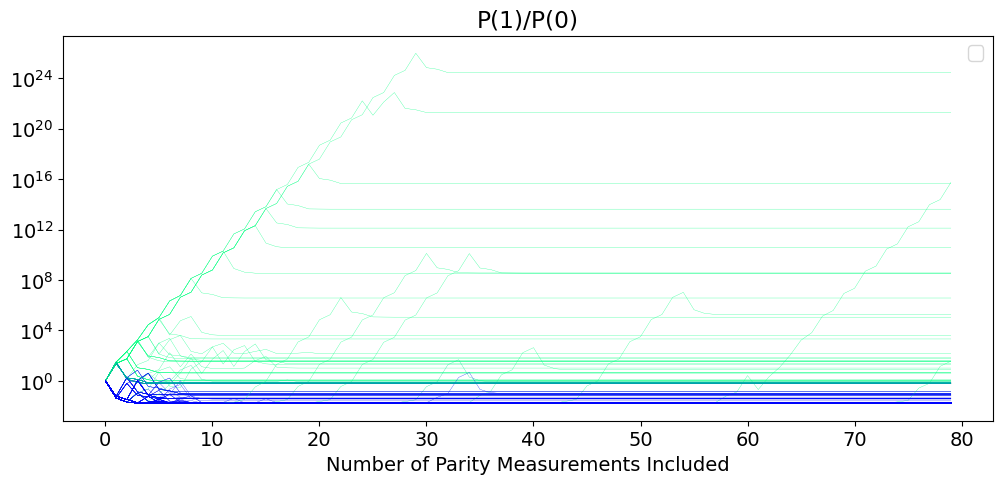

In [80]:
temp_data, attrs = prev_data(expt_path, '00112_cavity_temperature_sweep_parity_with_without_reset.h5')  # M1 dark counts
# temp_data, attrs = prev_data(expt_path, '00010_ParityTempExperiment.h5')   # efficiency
# threshold = attrs['config']['device']['readout']['threshold'][0]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = attrs['config']['device']['readout']['threshold'][0], readouts_per_rep=80)

meas_sequences = bb[0:10000: 5]

fig, (ax4) = plt.subplots(1, 1, figsize=(12, 5))

P1_lists = []
P0_lists = []

for meas_sequence in meas_sequences:
    P0_list, P1_list = find_probs_for_sequence(meas_sequence)
    P0_lists.append(P0_list)
    P1_lists.append(P1_list)

np.save('p1_lists2.npy', P1_lists)
np.save('p0_lists2.npy', P0_lists)

# P0_lists, P1_lists = find_probs_for_sequence(meas_sequences)

ratio_list = np.array(P1_lists) / np.array(P0_lists)

xlists = [ratio_list]
axs = [ax4]
titles = ['P(1)/P(0)']
mins = [1e-20]

for xlist, ax, title, min_ in zip(xlists, axs, titles, mins):
    for x in xlist:
        norm = matplotlib.colors.Normalize(
            vmin=min_, vmax=1
        )
        cmap = matplotlib.cm.get_cmap("winter")
        color = cmap(norm(x[-1]))
        ax.semilogy(
            x, "-", linewidth=0.2, alpha=1, color=color
        )
        ax.set_title(title)      

#ylabel('P(t=0)')
plt.xlabel('Number of Parity Measurements Included')
#title('Looking at a measurement sequence to get max threshold')
plt.legend()
plt.tight_layout

#### Back to temp calculation

In [78]:
full_threshold_list = [  1e2, 1e3, 1e4, 1e5, 1e7, 1e8, 1e9,  1e10,   1e11,   1e12, 1e13, 1e14, 1e15, 1e16, 1e17, 1e18, 1e19, 1e20, 1e21, 1e23, 1e25, 1e27, 1e30, 1e35, 1e40, 1e45, 1e50]

In [38]:
threshold_counts

[1657,
 1533,
 1360,
 1298,
 1070,
 1006,
 899,
 859,
 762,
 721,
 666,
 614,
 579,
 526,
 497,
 454,
 426,
 376,
 342,
 290,
 241,
 198,
 155,
 115,
 79,
 50,
 31]

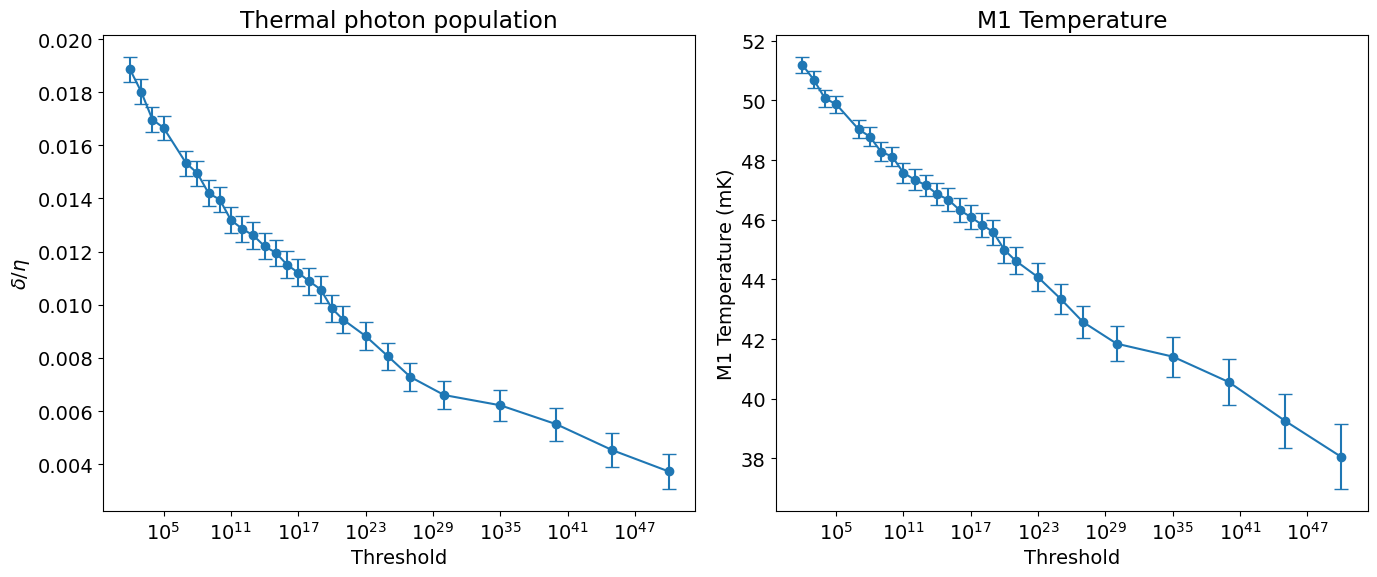

In [39]:
start_idx = 0
end_idx =  None

n = attrs['config']['expt']['reps']
dark_counts = np.array(threshold_counts) / n
dark_counts_err = np.sqrt(dark_counts *(1 - dark_counts) / n) # sqrt(p(1-p)/n)
frequency = 4.984 #+1.4

thermal_photon_population = []
thermal_photon_population_err = []
for i in range(len(dark_counts)):
    ratio = dark_counts[i] / efficiency_list[i]
    err  = ratio * np.sqrt((dark_counts_err[i] / dark_counts[i])**2 + (efficiency_list_err[i] / efficiency_list[i])**2)
    thermal_photon_population.append(ratio)
    thermal_photon_population_err.append(err)

now = np.array(thermal_photon_population) / 2
now_err = np.array(thermal_photon_population_err) / 2
tempr = []
tempr_err = []
for i in range(len(now)):
    temp = 48 * frequency / (np.log(1 + 1 / now[i]))
    temp_err = np.abs(temp * 1/(np.log(1 + 1 / now[i])) * (1/(1 + 1/now[i])) * now_err[i] / (now[i] **2))
    tempr.append(temp)
    tempr_err.append(temp_err)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot thermal photon population with error bars
ax1.errorbar(full_threshold_list[start_idx:end_idx], thermal_photon_population[start_idx:end_idx], yerr=thermal_photon_population_err[start_idx:end_idx], fmt='o-', capsize=5)
ax1.set_xscale('log')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('$\delta/\eta$ ')
ax1.set_title('Thermal photon population')

# Plot M1 Temperature with error bars
ax2.errorbar(full_threshold_list[start_idx:end_idx], tempr[start_idx:end_idx], yerr=tempr_err[start_idx:end_idx], fmt='o-', capsize=5)
ax2.set_xscale('log')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('M1 Temperature (mK)')
ax2.set_title('M1 Temperature')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [1066]:
attrs['config']['expt']

{'start': 0.01,
 'step': 1,
 'expts': 1,
 'parity_number': 80,
 'ramsey_freq': 0.0,
 'reps': 20000,
 'rounds': 1,
 'qubits': [0],
 'user_defined_freq': [False, 3425.30098176373, 7575, 0.035],
 'normalize': False,
 'active_reset': False,
 'man_reset': True,
 'storage_reset': True,
 'man_no': 1,
 'prepulse': True,
 'pre_sweep_pulse': [[944.25],
  [1000],
  [0.316677658],
  [0],
  [1],
  ['flat_top'],
  [0.005]],
 'readout_no_placeholder': 80}

In [921]:
i = 5
temp = 48 * frequency / (np.log(1 + 1 / now[i]))
np.abs(temp * 1/(np.log(1 + 1 / now[i])) * (1/(1 + 1/now[i])) * now_err[i] / (now[i] **2))

0.4443015985375665

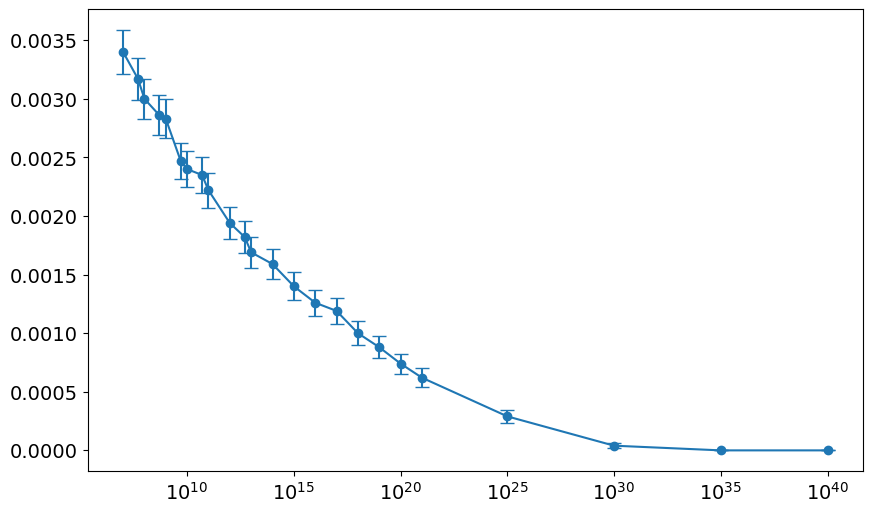

In [962]:
plt.errorbar(full_threshold_list, dark_counts, yerr=dark_counts_err, fmt='o-', capsize=5)
plt.xscale('log')

In [920]:
temp

40.922135993882144

In [915]:
i = -10
thermal_photon_population[i] * np.sqrt((dark_counts_err[i] / dark_counts[i])**2 + (efficiency_list_err[i] / efficiency_list[i])**2)

0.0003759365748738378

In [918]:
0.0003/(0.003

33.33333333333333

In [906]:
dark_counts[-3]

4e-05

In [911]:
thermal_photon_population_err[i]

0.00036647106255566675

#### Dataframe to save M1 with and without |1> data

In [49]:
columns = ['file_name', 'mode', 'T', 'E', 'threshold_list', 'counts_list', 'man_no_for_parity', 'reset', 'single_photon']
df = pd.DataFrame(columns=columns)

modes = ['M1', 'M2', 'M1', 'M1-S1', 'M1-S2', 'M1-S3', 'M1-S4', 'M1-S5', 'M1-S6', 'M1-S7', 'M1-D1', 'M1-C',
                'M2', 'M2-D2'] * 2
file_no_start = 110

for idx, mode in enumerate(modes): 
    # add row to dataframe
    file_no = int(file_no_start + idx)
    temp_data, attrs = prev_data(expt_path, f'{file_no:05d}_cavity_temperature_sweep_parity_with_without_reset.h5')
    reset = attrs['config']['expt']['active_reset']

    prepulse_len = 0
    if attrs['config']['expt']['prepulse']:
        prepulse_len = len(attrs['config']['expt']['pre_sweep_pulse'][0])

    single_photon = False
    if prepulse_len >1: 
        single_photon = True
    file_no = int(file_no_start + idx)

    df.loc[idx] = [f'{file_no:05d}_cavity_temperature_sweep_parity_with_without_reset.h5', mode, T, E, [0 for i in range(len(full_threshold_list))], [0 for i in range(len(full_threshold_list))], attrs['config']['expt']['man_no'], reset, single_photon]   
    print(f'{file_no:05d}_cavity_temperature_sweep_parity_with_without_reset.h5')

df


00110_cavity_temperature_sweep_parity_with_without_reset.h5
00111_cavity_temperature_sweep_parity_with_without_reset.h5
00112_cavity_temperature_sweep_parity_with_without_reset.h5
00113_cavity_temperature_sweep_parity_with_without_reset.h5
00114_cavity_temperature_sweep_parity_with_without_reset.h5
00115_cavity_temperature_sweep_parity_with_without_reset.h5
00116_cavity_temperature_sweep_parity_with_without_reset.h5
00117_cavity_temperature_sweep_parity_with_without_reset.h5
00118_cavity_temperature_sweep_parity_with_without_reset.h5
00119_cavity_temperature_sweep_parity_with_without_reset.h5
00120_cavity_temperature_sweep_parity_with_without_reset.h5
00121_cavity_temperature_sweep_parity_with_without_reset.h5
00122_cavity_temperature_sweep_parity_with_without_reset.h5
00123_cavity_temperature_sweep_parity_with_without_reset.h5
00124_cavity_temperature_sweep_parity_with_without_reset.h5
00125_cavity_temperature_sweep_parity_with_without_reset.h5
00126_cavity_temperature_sweep_parity_wi

,file_name,mode,T,E,threshold_list,counts_list,man_no_for_parity,reset,single_photon
0,00110_cavity_temperature_sweep_parity_with_wit...,M1,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.4983785974868261, 0.0016214025131738863], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,True
1,00111_cavity_temperature_sweep_parity_with_wit...,M2,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.4983785974868261, 0.0016214025131738863], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,False,True
2,00112_cavity_temperature_sweep_parity_with_wit...,M1,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.4983785974868261, 0.0016214025131738863], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False
3,00113_cavity_temperature_sweep_parity_with_wit...,M1-S1,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.4983785974868261, 0.0016214025131738863], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False
4,00114_cavity_temperature_sweep_parity_with_wit...,M1-S2,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.4983785974868261, 0.0016214025131738863], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False
5,00115_cavity_temperature_sweep_parity_with_wit...,M1-S3,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.4983785974868261, 0.0016214025131738863], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False
6,00116_cavity_temperature_sweep_parity_with_wit...,M1-S4,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.4983785974868261, 0.0016214025131738863], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False
7,00117_cavity_temperature_sweep_parity_with_wit...,M1-S5,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.4983785974868261, 0.0016214025131738863], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False
8,00118_cavity_temperature_sweep_parity_with_wit...,M1-S6,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.4983785974868261, 0.0016214025131738863], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False
9,00119_cavity_temperature_sweep_parity_with_wit...,M1-S7,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.4983785974868261, 0.0016214025131738863], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False


In [54]:
df[ 'threshold_list'][0] = list(full_threshold_list)
df[ 'counts_list'][0] = list(efficiency_list * attrs['config']['expt']['reps'])
df[ 'threshold_list'][2] = list(full_threshold_list)
df[ 'counts_list'][2] = list(threshold_counts)

C:\Users\26049\AppData\Local\Temp\ipykernel_5840\3010586431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ 'threshold_list'][0] = list(full_threshold_list)
C:\Users\26049\AppData\Local\Temp\ipykernel_5840\3010586431.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ 'counts_list'][0] = list(efficiency_list * attrs['config']['expt']['reps'])
C:\Users\26049\AppData\Local\Temp\ipykernel_5840\3010586431.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [55]:
df

,file_name,mode,T,E,threshold_list,counts_list,man_no_for_parity,reset,single_photon
0,00110_cavity_temperature_sweep_parity_with_wit...,M1,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.4983785974868261, 0.0016214025131738863], ...","[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[87849.0, 85081.0, 80145.0, 77923.0, 69796.0, ...",1,False,True
1,00111_cavity_temperature_sweep_parity_with_wit...,M2,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.4983785974868261, 0.0016214025131738863], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,False,True
2,00112_cavity_temperature_sweep_parity_with_wit...,M1,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.4983785974868261, 0.0016214025131738863], ...","[100.0, 1000.0, 10000.0, 100000.0, 10000000.0,...","[1657, 1533, 1360, 1298, 1070, 1006, 899, 859,...",1,False,False
3,00113_cavity_temperature_sweep_parity_with_wit...,M1-S1,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.4983785974868261, 0.0016214025131738863], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False
4,00114_cavity_temperature_sweep_parity_with_wit...,M1-S2,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.4983785974868261, 0.0016214025131738863], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False
5,00115_cavity_temperature_sweep_parity_with_wit...,M1-S3,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.4983785974868261, 0.0016214025131738863], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False
6,00116_cavity_temperature_sweep_parity_with_wit...,M1-S4,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.4983785974868261, 0.0016214025131738863], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False
7,00117_cavity_temperature_sweep_parity_with_wit...,M1-S5,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.4983785974868261, 0.0016214025131738863], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False
8,00118_cavity_temperature_sweep_parity_with_wit...,M1-S6,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.4983785974868261, 0.0016214025131738863], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False
9,00119_cavity_temperature_sweep_parity_with_wit...,M1-S7,"[[0.9885400581248439, 0.011459941875156051, 0....","[[0.4983785974868261, 0.0016214025131738863], ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,False,False


#### Save dataframe 

In [56]:
folder = os.path.join(data_parent, 'RAM_paper_results', 'datasets')
file_name = 'Cavity_Temp_Parity.csv'
file_path = os.path.join(folder, file_name)

# Ensure the directory exists
os.makedirs(folder, exist_ok=True)

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False)

print(f"DataFrame saved to {file_path}")

DataFrame saved to H:\Shared drives\SLab\Multimode\experiment\240911\RAM_paper_results\datasets\Cavity_Temp_Parity.csv


Procedure: 

1. Load single photon in M1 and perform N = 40 repeated parity measurements (total of N = 1e5 shots). These parameters set the maximum threshold to be $\lambda_{max} \approx 10^{20}$

2. Through Hidden Markov Analysis, we find the number of photons measured $n_{meas}$ for a range of thresholds $\lambda$ . Given the equation $$n_{meas} (\lambda) = \eta_{true} (\lambda) \times 1 \text{photon injected} + \delta (\lambda) \approx \eta(\lambda)$$, we compute get efficiencies for each threshold $\eta(\lambda)$. Here we drop the false positive probability $\delta < 0.01 <<\eta_{true}$ since it is small compared to the true efficiency. 

3. To calculate mode temperature, we repeat step 1 with no injected photon. We find the thermal photons by normalizing the false positive probability $\delta$ with the efficiency $\eta(\lambda)$
$$ n_{thermal} (\lambda) = n_{meas}(\lambda) / \eta(\lambda) = \delta(\lambda) / \eta(\lambda)$$




### Use above efficiencies to calculate for all modes

In [850]:
file_no_list = np.arange(13, 20, 1)
mode_labels = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']
# threshold_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

threshold_counts_list = []
current_running_dict = m1_running_dict
for file_no in file_no_list:
    temp_data, attrs = prev_data(expt_path, f'{file_no:05d}_cavity_temperature_sweep_parity.h5')
    aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = -63.47477176210509, readouts_per_rep=40)
    threshold_counts, current_running_dict = compute_threshold_counts(bb, full_threshold_list, current_running_dict)
    threshold_counts_list.append(threshold_counts)



Processing: 100%|██████████| 100000/100000 [02:42<00:00, 614.63it/s]


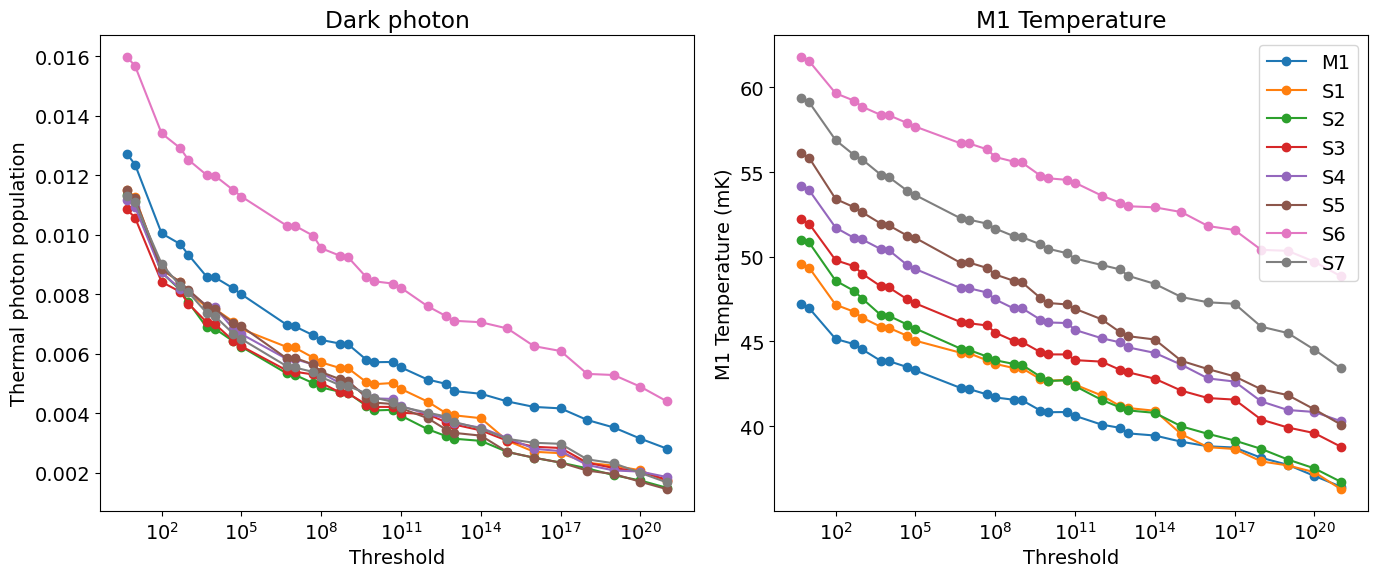

In [852]:
frequencies = 4.984 + (np.array([0, 349.41, 520.93, 696.66, 875.83, 1053.42, 1245.18, 1422.925]) * 1e-3)
# efficiency_list = np.array(efficiency_list) * 1e-5#np.array([12737, 12067, 11894, 11596, 11379, 10836, 10765, 10240, 10092])/20000

plot_thermal_photon_and_temperature(threshold_counts_list, efficiency_list, full_threshold_list, frequencies, mode_labels)

In [714]:
frequencies

array([4.98    , 5.32941 , 5.50093 , 5.67666 , 5.85583 , 6.03342 ,
       6.22518 , 6.402925])

## Storage with Active Reset


### Calculate Efficiency

In [853]:
temp_data, attrs = prev_data(expt_path, '00011_ParityTempExperiment.h5')
attrs['config']['device']['readout']['threshold']

[-64.47477176210509]

In [854]:
temp_data, attrs = prev_data(expt_path, '00011_ParityTempExperiment.h5')
threshold_list = [10]
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = attrs['config']['device']['readout']['threshold'][0], readouts_per_rep=40)
threshold_counts, running_dict = compute_threshold_counts(bb, threshold_list)
active_reset_running_dict = running_dict.copy()

Processing: 100%|██████████| 107500/107500 [24:34<00:00, 72.93it/s] 


In [855]:
full_threshold_list = [ 5, 10, 100, 500, 1000, 5000, 10000, 50000, 100000, 5e6, 1e7, 5e7, 1e8, 5e8, 1e9, 5e9, 1e10, 5e10, 1e11, 5e12, 1e12, 1e13, 1e14, 1e15, 1e16, 1e17, 1e18, 1e19, 1e20, 1e21]
threshold_counts, running_dict = compute_threshold_counts(bb, full_threshold_list, active_reset_running_dict)

Processing: 100%|██████████| 107500/107500 [23:14<00:00, 77.10it/s] 


In [856]:
# reorder full threshold list so its lowest to highest and threshold counts are in the same order
full_threshold_list, threshold_counts = zip(*sorted(zip(full_threshold_list, threshold_counts)))

#### Looking at maximal attainable threshold

In [ ]:
temp_data, attrs = prev_data(expt_path, '00010_ParityTempExperiment.h5')
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = -88.47477176210509, readouts_per_rep=40)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

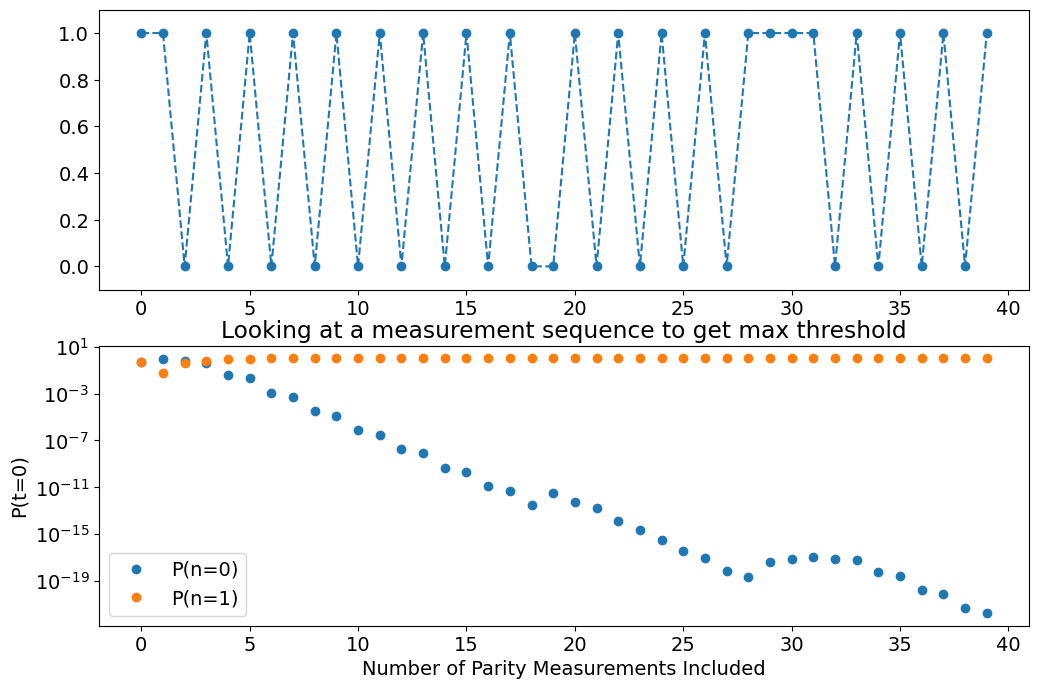

In [ ]:
P0_list = []
P1_list = []
full_meas_sequence = bb[80000]

for ii in range (len(full_meas_sequence)):
    meas_sequence = full_meas_sequence[0:ii + 1]
    gamma_first_row = wrapper_gamma(meas_sequence, running_dict = {'meas_sequence':[], 'gamma_first_row':[]})
    P0 = gamma_first_row[0] + gamma_first_row[1]
    P1 = gamma_first_row[2] + gamma_first_row[3]
    P0_list.append(P0)
    P1_list.append(P1)

# plot the P0 and P1 probabilities
figure(figsize = (12,8))

# plot measurement record
subplot(2,1,1)
plot(meas_sequence, 'o--')
ylim(-0.1, 1.1)

# plot reconstructed probabilities for subsets of the measurement record
subplot(2,1,2)
semilogy(P0_list, 'o', label= "P(n=0)")
semilogy(P1_list, 'o', label= "P(n=1)")
#         axhline(1e-9)
#         plot(P0_first, 'o', label= "P(n=0)")
#         plot(P1_first, 'o', label= "P(n=1)")
#         axhline(1e-8)
#         ylim(1e-16,1e0)
ylabel('P(t=0)')
xlabel('Number of Parity Measurements Included')
title('Looking at a measurement sequence to get max threshold')
legend()
tight_layout

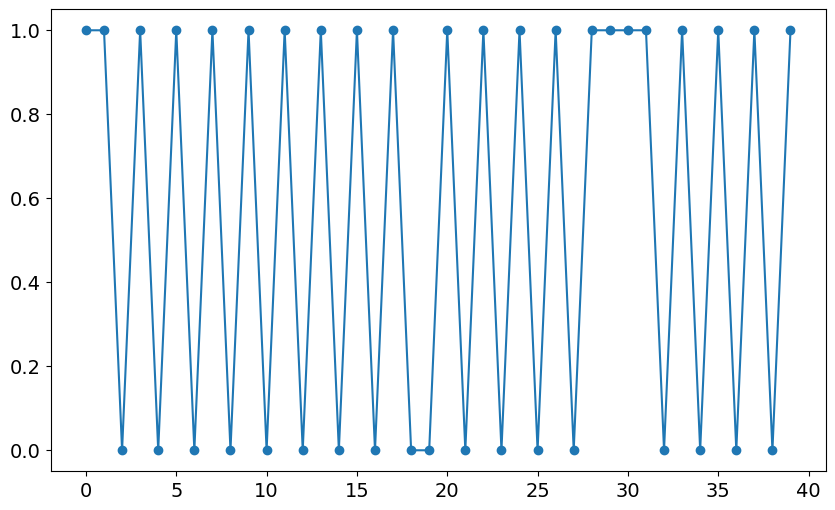

In [ ]:
plt.plot(bb[80000], '-o')

#### Now computing efficiency

In [857]:
attrs['config']['expt'] 

{'start': 0.01,
 'step': 1,
 'expts': 1,
 'parity_number': 40,
 'ramsey_freq': 0.0,
 'reps': 100000,
 'rounds': 1,
 'qubits': [0],
 'user_defined_freq': [False, 3425.30098176373, 7575, 0.035],
 'normalize': False,
 'active_reset': True,
 'man_reset': True,
 'storage_reset': True,
 'prepulse': True,
 'pre_sweep_pulse': [[3568.1515953227604, 3425.5564066067, 2007.0],
  [10716, 8236, 15000],
  [0, 0, 0.6056817916987671],
  [0, 0, 0],
  [2, 2, 0],
  ['g', 'g', 'flat_top'],
  [0.035, 0.035, 0.005]],
 'readout_no_placeholder': 40}

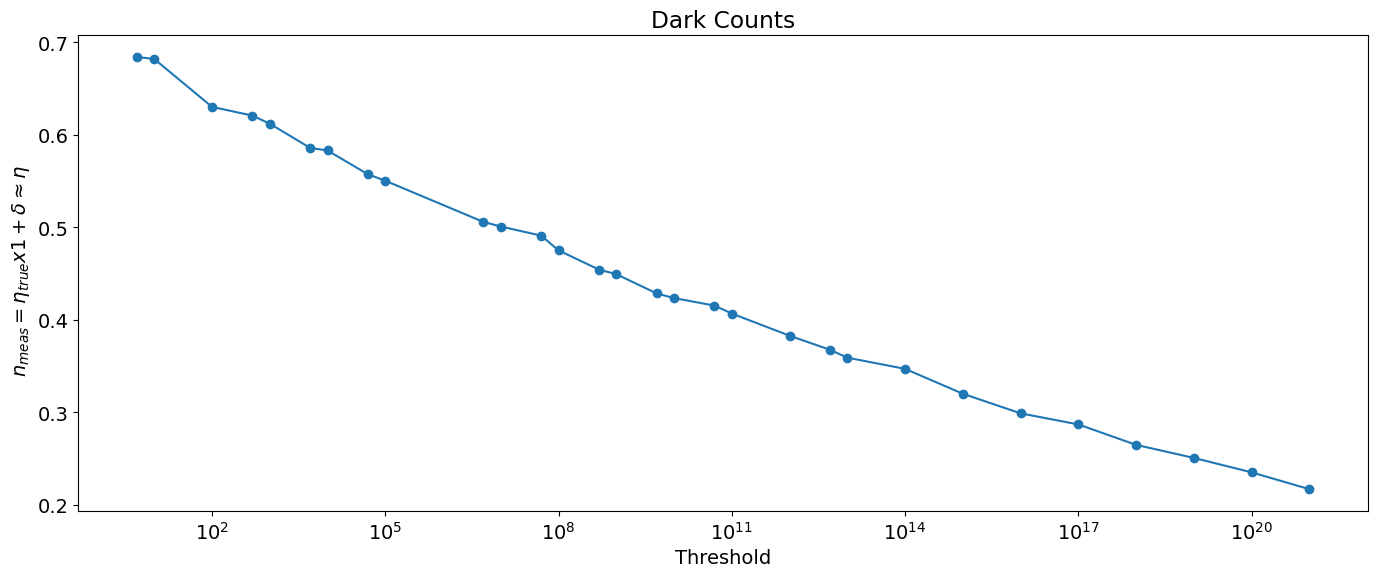

In [858]:
dark_counts = np.array(threshold_counts) / 1e5

thermal_photon_population = []
# for i in range(len(dark_counts)):
#     thermal_photon_population.append(dark_counts[i] / efficiency_list[i])



# Create subplots
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 6))

# Plot thermal photon population
ax1.plot(full_threshold_list, dark_counts, 'o-')
ax1.set_xscale('log')
ax1.set_xlabel('Threshold')
ax1.set_ylabel(r' $n_{meas} = \eta_{true} x 1 + \delta \approx \eta$')
ax1.set_title('Dark Counts')


# plt.suptitle(str('M1') + ' Thermal Photon Population Temperature vs. Threshold')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [859]:
efficiency_list = np.array(threshold_counts) * 1e-5

In [860]:
efficiency_list 

array([0.68422, 0.68201, 0.63019, 0.62082, 0.61202, 0.58586, 0.58308,
       0.55731, 0.55039, 0.50581, 0.50087, 0.49098, 0.47506, 0.45429,
       0.44933, 0.42851, 0.42349, 0.41536, 0.40676, 0.38281, 0.36757,
       0.35908, 0.34694, 0.32004, 0.29885, 0.28687, 0.26476, 0.25065,
       0.23505, 0.21682])

In [ ]:
# efficiency_list = [0.6611 , 0.63235, 0.62515, 0.61114, 0.60217, 0.57661, 0.57405,
#        0.54543, 0.53883, 0.49583, 0.49091, 0.4786 , 0.46403, 0.45069,
#        0.44733]

### Use above efficiency to calculate temperature for M1
This is really the efficiency-normalized false positive  probability for M1

In [1098]:
file_no = 6
temp_data, attrs = prev_data(expt_path, f'{file_no:05d}_cavity_temperature_sweep_parity.h5')
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold =  attrs['config']['device']['readout']['threshold'][0],
                              readouts_per_rep=40)
threshold_counts, m1_running_dict = compute_threshold_counts(bb, full_threshold_list, m1_running_dict)


Processing: 100%|██████████| 107500/107500 [05:47<00:00, 309.62it/s]


In [1096]:
full_threshold_list

(10000000.0,
 50000000.0,
 100000000.0,
 500000000.0,
 1000000000.0,
 5000000000.0,
 10000000000.0,
 50000000000.0,
 100000000000.0,
 1000000000000.0,
 5000000000000.0,
 10000000000000.0,
 100000000000000.0,
 1000000000000000.0,
 1e+16,
 1e+17,
 1e+18,
 1e+19,
 1e+20,
 1e+21,
 1e+25,
 1e+30,
 1e+35,
 1e+40,
 1e+45,
 1e+50)

In [1099]:
threshold_counts

[1277,
 1199,
 1153,
 1074,
 1064,
 952,
 922,
 891,
 839,
 767,
 692,
 673,
 642,
 537,
 459,
 426,
 364,
 324,
 281,
 226,
 106,
 14,
 0,
 0,
 0,
 0]

C:\Users\26049\AppData\Local\Temp\ipykernel_24012\2575242693.py:12: RuntimeWarning: invalid value encountered in scalar divide
  ratio = dark_counts[i] / efficiency_list[i]
C:\Users\26049\AppData\Local\Temp\ipykernel_24012\2575242693.py:13: RuntimeWarning: invalid value encountered in scalar divide
  err  = ratio * np.sqrt((dark_counts_err[i] / dark_counts[i])**2 + (efficiency_list_err[i] / efficiency_list[i])**2)


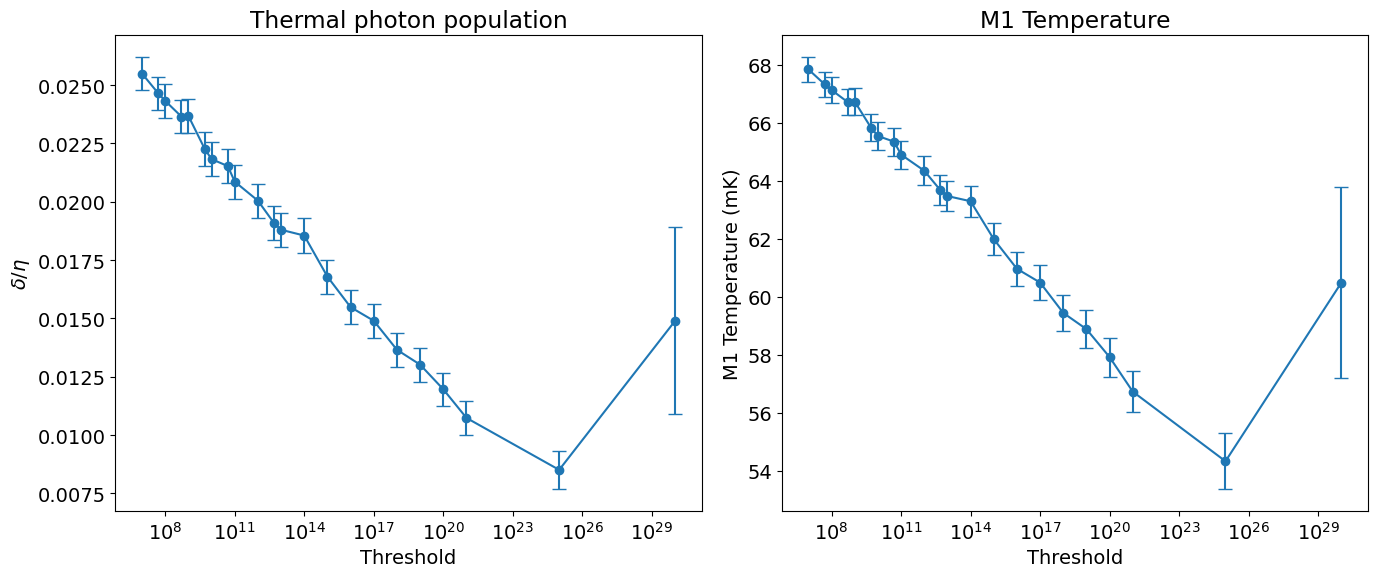

In [1101]:
start_idx = 0
end_idx =  -4

n = attrs['config']['expt']['reps']
dark_counts = np.array(threshold_counts) / n
dark_counts_err = np.sqrt(dark_counts *(1 - dark_counts) / n) # sqrt(p(1-p)/n)
frequency = 4.984 +1.2

thermal_photon_population = []
thermal_photon_population_err = []
for i in range(len(dark_counts)):
    ratio = dark_counts[i] / efficiency_list[i]
    err  = ratio * np.sqrt((dark_counts_err[i] / dark_counts[i])**2 + (efficiency_list_err[i] / efficiency_list[i])**2)
    thermal_photon_population.append(ratio)
    thermal_photon_population_err.append(err)

now = np.array(thermal_photon_population) / 2
now_err = np.array(thermal_photon_population_err) / 2
tempr = []
tempr_err = []
for i in range(len(now)):
    temp = 48 * frequency / (np.log(1 + 1 / now[i]))
    temp_err = np.abs(temp * 1/(np.log(1 + 1 / now[i])) * (1/(1 + 1/now[i])) * now_err[i] / (now[i] **2))
    tempr.append(temp)
    tempr_err.append(temp_err)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot thermal photon population with error bars
ax1.errorbar(full_threshold_list[start_idx:end_idx], thermal_photon_population[start_idx:end_idx], yerr=thermal_photon_population_err[start_idx:end_idx], fmt='o-', capsize=5)
ax1.set_xscale('log')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('$\delta/\eta$ ')
ax1.set_title('Thermal photon population')

# Plot M1 Temperature with error bars
ax2.errorbar(full_threshold_list[start_idx:end_idx], tempr[start_idx:end_idx], yerr=tempr_err[start_idx:end_idx], fmt='o-', capsize=5)
ax2.set_xscale('log')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('M1 Temperature (mK)')
ax2.set_title('M1 Temperature')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [1097]:
thermal_photon_population

[0.012158843612114919,
 0.011410127258896816,
 0.011244962973902402,
 0.011011518047878081,
 0.01088456573031207,
 0.009922074275150352,
 0.009848718009422571,
 0.00966627196056161,
 0.009300012433171701,
 0.008912935518440105,
 0.008604048315040538,
 0.008324952508660185,
 0.008322496749024707,
 0.007566756300418986,
 0.006948660864872159,
 0.0067499038226139264,
 0.005890076908647533,
 0.004982320797171327,
 0.0047254150702426565,
 0.003942805567431476,
 0.002809665248454684,
 0.00851063829787234,
 nan,
 nan,
 nan,
 nan]

Procedure: 

1. Load single photon in M1 and perform N = 40 repeated parity measurements (total of N = 1e5 shots). These parameters set the maximum threshold to be $\lambda_{max} \approx 10^{20}$

2. Through Hidden Markov Analysis, we find the number of photons measured $n_{meas}$ for a range of thresholds $\lambda$ . Given the equation $$n_{meas} (\lambda) = \eta_{true} (\lambda) \times 1 \text{photon injected} + \delta (\lambda) \approx \eta(\lambda)$$, we compute get efficiencies for each threshold $\eta(\lambda)$. Here we drop the false positive probability $\delta < 0.01 <<\eta_{true}$ since it is small compared to the true efficiency. 

3. To calculate mode temperature, we repeat step 1 with no injected photon. We find the thermal photons by normalizing the false positive probability $\delta$ with the efficiency $\eta(\lambda)$
$$ n_{thermal} (\lambda) = n_{meas}(\lambda) / \eta(\lambda) = \delta(\lambda) / \eta(\lambda)$$




### Use above efficiencies to calculate for all modes

In [863]:
file_no_list = np.arange(0, 8, 1)
mode_labels = ['M1', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']
# threshold_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]

threshold_counts_list = []
current_running_dict = m1_running_dict
for file_no in file_no_list:
    temp_data, attrs = prev_data(expt_path, f'{file_no:05d}_cavity_temperature_sweep_parity.h5')
    aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = -63.47477176210509, readouts_per_rep=40)
    threshold_counts, current_running_dict = compute_threshold_counts(bb, full_threshold_list, current_running_dict)
    threshold_counts_list.append(threshold_counts)



Processing:   2%|▏         | 1729/107500 [00:04<04:25, 398.89it/s]


KeyboardInterrupt: 

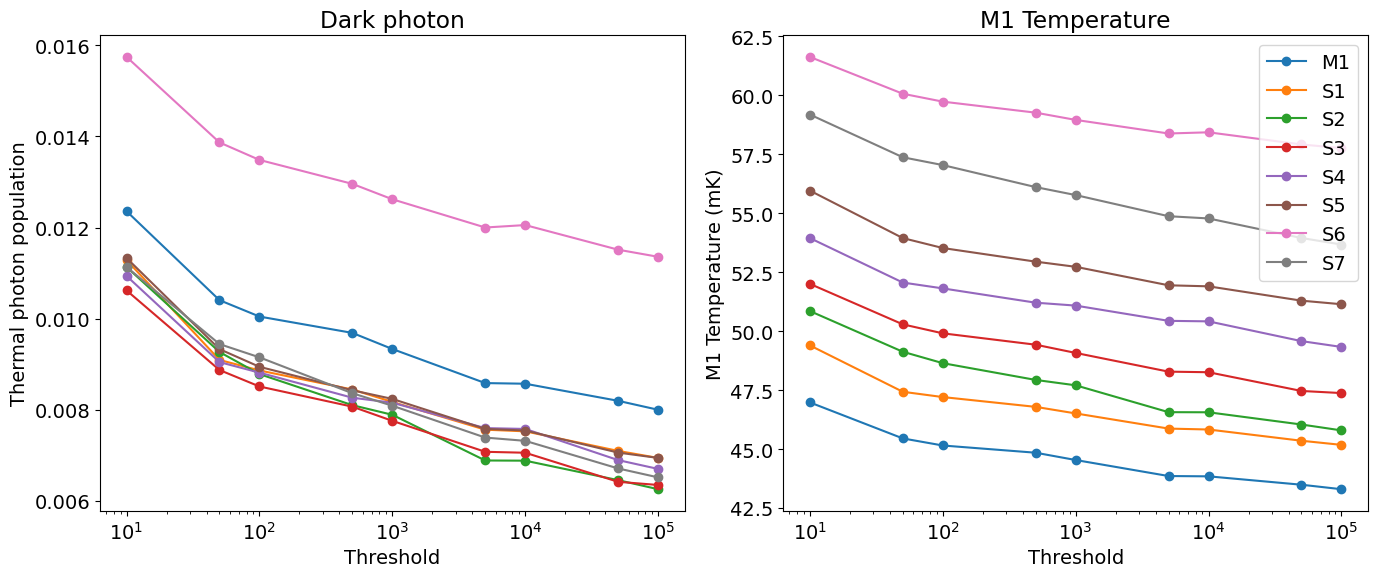

In [ ]:
frequencies = 4.984 + (np.array([0, 349.41, 520.93, 696.66, 875.83, 1053.42, 1245.18, 1422.925]) * 1e-3)
# efficiency_list = np.array(efficiency_list) * 1e-5#np.array([12737, 12067, 11894, 11596, 11379, 10836, 10765, 10240, 10092])/20000

plot_thermal_photon_and_temperature(threshold_counts_list, efficiency_list, threshold_list, frequencies, mode_labels)

### Sandbox

In [735]:
temp_data, attrs = prev_data(expt_path, '00010_ParityTempExperiment.h5')
# temp_data, attrs = prev_data(expt_path, '00004_cavity_temperature_sweep_parity.h5')
aa, bb = parity_temp_display(temp_data, attrs, active_reset=False, threshold = -88.47477176210509, readouts_per_rep=40)

In [736]:
attrs['config']['expt']

{'start': 0.01,
 'step': 1,
 'expts': 1,
 'parity_number': 40,
 'ramsey_freq': 0.0,
 'reps': 100000,
 'rounds': 1,
 'qubits': [0],
 'user_defined_freq': [False, 3425.30098176373, 7575, 0.035],
 'normalize': False,
 'active_reset': False,
 'man_reset': True,
 'storage_reset': True,
 'prepulse': True,
 'pre_sweep_pulse': [[3568.1515953227604, 3425.5564066067, 2007.0],
  [10716, 8236, 15000],
  [0, 0, 0.6056817916987671],
  [0, 0, 0],
  [2, 2, 0],
  ['g', 'g', 'flat_top'],
  [0.035, 0.035, 0.005]],
 'readout_no_placeholder': 40}

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

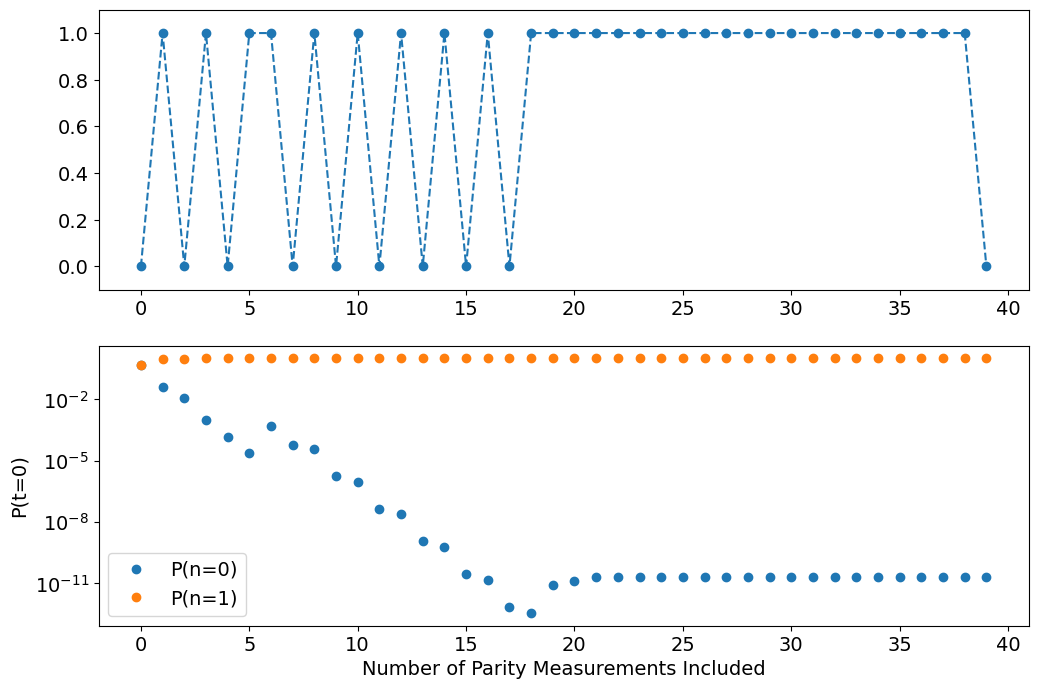

In [739]:
meas_sequence = bb[5000]

running_dict = {'meas_sequence': [], 
                'gamma_first_row': []} # stores gamma

# want to compute the probabilities of 0 or 1 photon initially in the cavity
P0_first = []
P1_first = []

# iteratively calculate probabilities using one additional measurement at a time
# observe how probabilities 'evolve' with more meaurements in the recrod
for ii in range (len(meas_sequence)):
    
    # analyze subeset of measurment record from beginning to ii-th measuement
    # could be implemented online to do feedback in the measurement
    temp_meas_sequence = meas_sequence[0:ii+1]
    
    # forward-backward algorithm return state probabilities at each step
    # gamma_matrix = gamma(temp_meas_sequence, T, E)
    
    gamma_first_row = wrapper_gamma(temp_meas_sequence, running_dict)
    P0 = gamma_first_row[0] + gamma_first_row[1]
    P1 = gamma_first_row[2] + gamma_first_row[3]

    # pick off probability of cavitiy state at the beginning, 0 in the first index
    # sum over qubit state probability, second index
    P0_first.append(P0)
    P1_first.append(P1)

figure(figsize = (12,8))

# plot measurement record
subplot(2,1,1)
plot(meas_sequence, 'o--')
ylim(-0.1, 1.1)

# plot reconstructed probabilities for subsets of the measurement record
subplot(2,1,2)
semilogy(P0_first, 'o', label= "P(n=0)")
semilogy(P1_first, 'o', label= "P(n=1)")
#         axhline(1e-9)
#         plot(P0_first, 'o', label= "P(n=0)")
#         plot(P1_first, 'o', label= "P(n=1)")
#         axhline(1e-8)
#         ylim(1e-16,1e0)
ylabel('P(t=0)')
xlabel('Number of Parity Measurements Included')
legend()
tight_layout

In [684]:
len(bb)

100000

In [689]:
from tqdm import tqdm

In [695]:

# plot the function: efficiency vs threshold
threshold_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]
efficiency_list = np.array([12737, 12067, 11894, 11596, 11379, 10836, 10765, 10240, 10092])/20000

threshold_counts = compute_threshold_counts(bb, threshold_list)

# print threshold counts and corresponding threshold
for jdx, threshold in enumerate(threshold_list):
    print(f'Threshold: {threshold}, Counts: {threshold_counts[jdx]}')

Processing: 100%|██████████| 107500/107500 [00:25<00:00, 4280.28it/s]

Threshold: 10, Counts: 1423
Threshold: 50, Counts: 1200
Threshold: 100, Counts: 1133
Threshold: 500, Counts: 1036
Threshold: 1000, Counts: 1010
Threshold: 5000, Counts: 915
Threshold: 10000, Counts: 894
Threshold: 50000, Counts: 790
Threshold: 100000, Counts: 753


Text(0.5, 1.0, 'Dark photon')

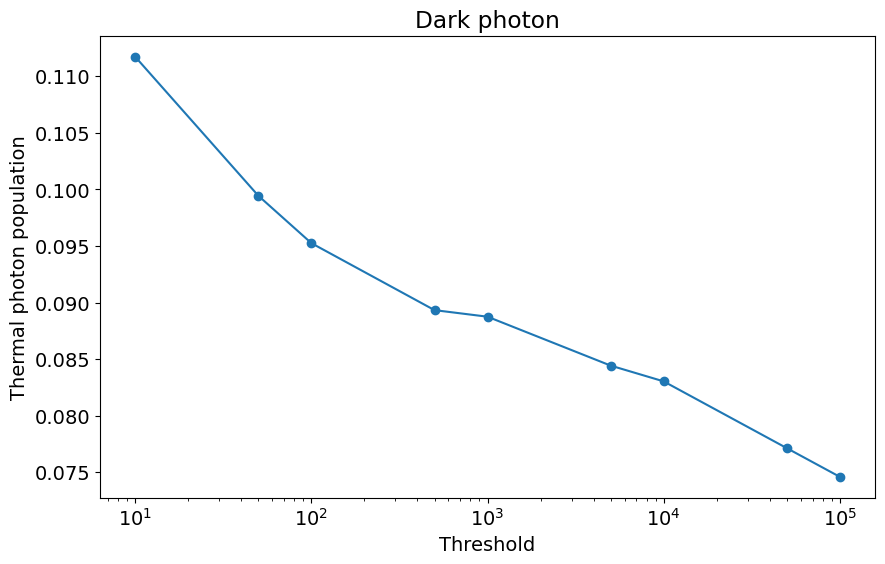

In [696]:
dark_counts = np.array(threshold_counts)/20000

thermal_photon_population = []
for i in range(len(dark_counts)):
    thermal_photon_population.append(dark_counts[i]/efficiency_list[i])

plt.plot(threshold_list, thermal_photon_population, 'o-')
plt.xscale('log')
plt.xlabel('Threshold')
plt.ylabel('Thermal photon population')
plt.title('Dark photon')


Text(0, 0.5, 'M1 Temperature (mK)')

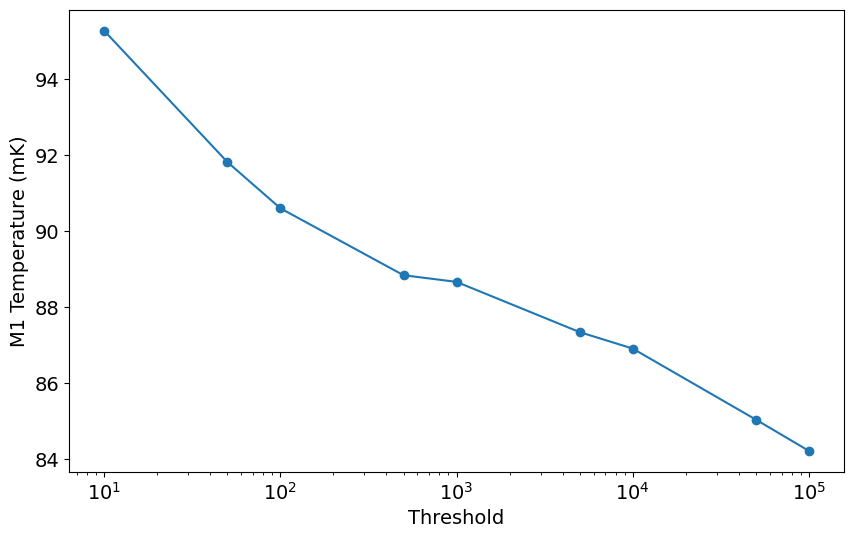

In [697]:

freq = 4.984 + 0.17 + 4* 0.17
now = np.array(thermal_photon_population)/2
tempr = []
for i in range(len(now)):
    tempr.append(48*freq/(np.log(1+1/now[i])))
plt.plot(threshold_list, tempr, 'o-')
plt.xscale('log')
plt.xlabel('Threshold')
plt.ylabel('M1 Temperature (mK)')

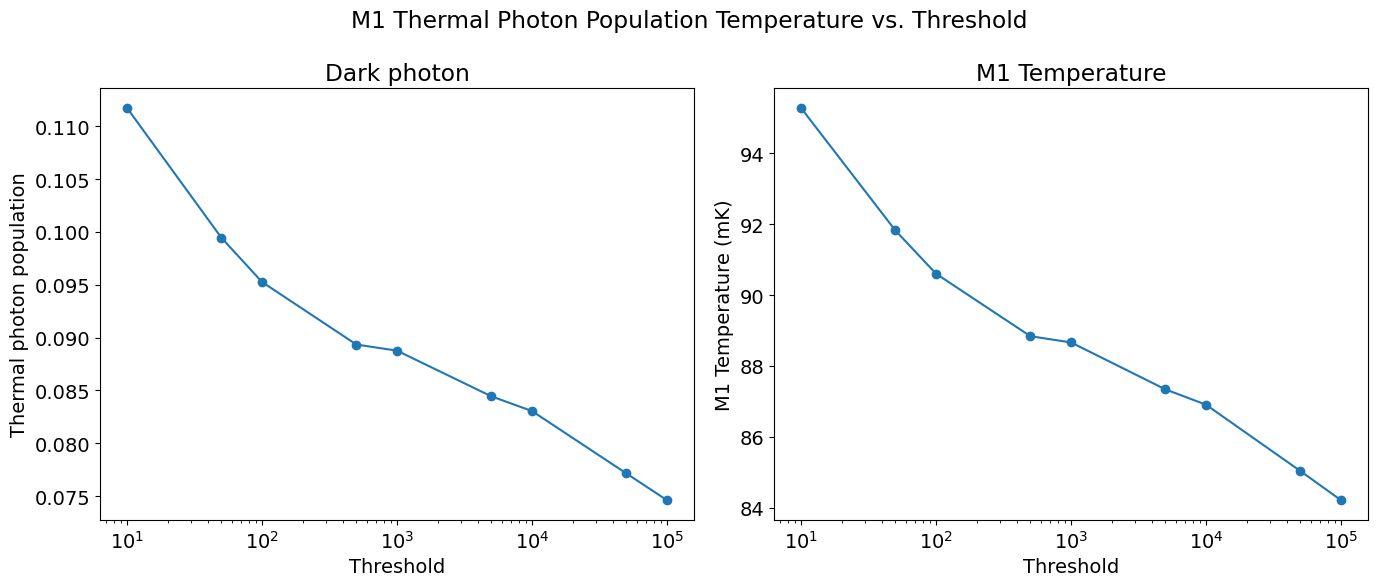

In [702]:
def plot_thermal_photon_and_temperature(threshold_counts, efficiency_list, threshold_list, frequency, mode_label='M1'):
    dark_counts = np.array(threshold_counts) / 20000

    thermal_photon_population = []
    for i in range(len(dark_counts)):
        thermal_photon_population.append(dark_counts[i] / efficiency_list[i])

    now = np.array(thermal_photon_population) / 2
    tempr = []
    for i in range(len(now)):
        tempr.append(48 * frequency / (np.log(1 + 1 / now[i])))

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot thermal photon population
    ax1.plot(threshold_list, thermal_photon_population, 'o-')
    ax1.set_xscale('log')
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Thermal photon population')
    ax1.set_title('Dark photon')

    # Plot M1 Temperature
    ax2.plot(threshold_list, tempr, 'o-')
    ax2.set_xscale('log')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('M1 Temperature (mK)')
    ax2.set_title('M1 Temperature')

    plt.suptitle(str(mode_label) + ' Thermal Photon Population Temperature vs. Threshold')

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

# Example usage
#threshold_counts = [100, 200, 300, 400, 500, 600, 700, 800]
threshold_list = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]
efficiency_list = np.array([12737, 12067, 11894, 11596, 11379, 10836, 10765, 10240, 10092])/20000
plot_thermal_photon_and_temperature(threshold_counts, efficiency_list, threshold_list, frequency)